In [1]:
!pip install wrds

   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   --------------------------- ------------ 1.8/2.7 MB 9.2 MB/s eta 0:00:01
   ---------------------------------------- 2.7/2.7 MB 8.7 MB/s eta 0:00:00

   ---------------------------------------- 2/2 [wrds]



In [1]:
import pandas as pd
import numpy as np
import wrds
from pandas.tseries.offsets import MonthEnd
import matplotlib.pyplot as plt
import seaborn as sns
import wrds
from tqdm.auto import tqdm

### EVERYTHING BELOW GOOD ###

In [3]:
"""
Capital IQ Earnings Call Transcript Data Extractor via WRDS
SCALED VERSION: 5 Years of US Earnings Calls (2020-2024)
Target: 5,000-10,000 transcripts for neural network training
"""

import wrds
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import warnings
import os
warnings.filterwarnings('ignore')

# For file download in Colab/Jupyter
try:
    from google.colab import files
    IN_COLAB = True
except:
    IN_COLAB = False

class ScaledTranscriptExtractor:
    def __init__(self, wrds_username=None):
        """Initialize connection to WRDS database"""
        print("Connecting to WRDS...")
        self.db = wrds.Connection(wrds_username=wrds_username)
        print("✓ Connected to WRDS successfully")

    def get_transcripts_by_date_range(self, start_date, end_date):
        """
        Get transcripts for a specific date range
        US COMPANIES ONLY, filtered for good data quality
        """
        print(f"\n{'='*70}")
        print(f"Fetching transcripts: {start_date} to {end_date}")
        print('='*70)

        # Get transcript details - FILTERED FOR US COMPANIES
        query1 = f"""
        SELECT DISTINCT
            d.companyid,
            d.transcriptid,
            d.headline,
            d.mostimportantdateutc,
            d.transcriptcreationdate_utc,
            d.companyname,
            d.keydeveventtypename
        FROM ciq.wrds_transcript_detail d
        INNER JOIN ciq.wrds_gvkey g
            ON d.companyid = g.companyid
            AND g.primaryflag = 1
        INNER JOIN comp.company c
            ON g.gvkey = c.gvkey
        WHERE d.transcriptcreationdate_utc BETWEEN '{start_date}' AND '{end_date}'
        AND d.companyid IS NOT NULL
        AND c.loc = 'USA'
        AND c.fic = 'USA'
        AND d.keydeveventtypename LIKE '%%Earnings%%'
        ORDER BY d.transcriptcreationdate_utc DESC
        """

        print("  Fetching transcript metadata...")
        transcript_meta = self.db.raw_sql(query1)
        print(f"  ✓ Found {len(transcript_meta)} earnings call transcripts")

        if len(transcript_meta) == 0:
            return pd.DataFrame()

        return transcript_meta

    def get_transcript_text_batch(self, transcript_ids):
        """
        Get transcript text for a batch of IDs
        Processes in chunks to avoid query size limits
        """
        if len(transcript_ids) == 0:
            return pd.DataFrame()

        ids_str = ",".join([str(int(tid)) for tid in transcript_ids])

        query = f"""
        SELECT
            transcriptid,
            componentorder,
            componenttext
        FROM ciq.ciqtranscriptcomponent
        WHERE transcriptid IN ({ids_str})
        AND componenttext IS NOT NULL
        ORDER BY transcriptid, componentorder
        """

        components = self.db.raw_sql(query)
        return components

    def add_ticker_info(self, transcripts_df):
        """Add ticker information using WRDS ticker table"""
        if len(transcripts_df) == 0:
            return pd.DataFrame()

        company_ids = transcripts_df['companyid'].unique().tolist()

        # Process in chunks to avoid query size limits
        chunk_size = 500
        all_tickers = []

        for i in range(0, len(company_ids), chunk_size):
            chunk = company_ids[i:i+chunk_size]
            ids_str = ",".join([str(int(cid)) for cid in chunk])

            ticker_query = f"""
            SELECT DISTINCT
                t.companyid,
                t.ticker,
                t.companyname
            FROM ciq.wrds_ticker t
            WHERE t.companyid IN ({ids_str})
            AND t.primaryflag = 1
            """

            tickers = self.db.raw_sql(ticker_query)
            all_tickers.append(tickers)

        if all_tickers:
            all_tickers_df = pd.concat(all_tickers, ignore_index=True)
            transcripts_with_tickers = transcripts_df.merge(
                all_tickers_df[['companyid', 'ticker']],
                on='companyid',
                how='inner'
            )
            return transcripts_with_tickers

        return pd.DataFrame()

    def aggregate_transcripts(self, transcripts_df):
        """Combine transcript components into full documents"""
        if len(transcripts_df) == 0:
            return pd.DataFrame()

        aggregated = transcripts_df.groupby('transcriptid').agg({
            'companyid': 'first',
            'headline': 'first',
            'transcriptcreationdate_utc': 'first',
            'mostimportantdateutc': 'first',
            'companyname': 'first',
            'ticker': 'first',
            'keydeveventtypename': 'first',
            'componenttext': lambda x: '\n\n'.join(x.dropna())
        }).reset_index()

        aggregated = aggregated.rename(columns={
            'componenttext': 'full_transcript_text',
            'keydeveventtypename': 'event_type'
        })

        # Convert dates
        aggregated['call_date'] = pd.to_datetime(aggregated['mostimportantdateutc']).dt.date

        return aggregated

    def get_permno_from_ticker(self, companyid, reference_date):
        """Map CIQ companyid → Compustat GVKEY → CRSP PERMNO"""
        try:
            query = f"""
            SELECT l.lpermno as permno
            FROM ciq.wrds_gvkey g
            JOIN crsp.ccmxpf_linktable l
                ON g.gvkey = l.gvkey
            WHERE g.companyid = {companyid}
              AND l.linktype IN ('LU', 'LC')
              AND l.linkprim IN ('P', 'C')
              AND l.linkdt <= '{reference_date}'
              AND (l.linkenddt IS NULL OR l.linkenddt >= '{reference_date}')
            ORDER BY l.linkdt DESC
            LIMIT 1
            """
            result = self.db.raw_sql(query)
            if len(result) > 0:
                return int(result['permno'].iloc[0])
        except Exception as e:
            pass
        return None

    def map_companies_to_permnos(self, transcripts_df):
        """Map companyids to CRSP PERMNOs"""
        if len(transcripts_df) == 0:
            return pd.DataFrame()

        unique_pairs = transcripts_df[['companyid', 'call_date']].drop_duplicates()
        mappings = []

        total = len(unique_pairs)
        for idx, row in unique_pairs.iterrows():
            if idx % 100 == 0:
                print(f"    Mapping PERMNOs: {idx}/{total}...")

            permno = self.get_permno_from_ticker(row['companyid'], row['call_date'])
            if permno:
                mappings.append({
                    'companyid': row['companyid'],
                    'call_date': row['call_date'],
                    'permno': permno
                })

        permno_df = pd.DataFrame(mappings)
        return permno_df

    def get_stock_prices(self, transcripts_df, window_before=5, window_after=5):
        """
        Get closing price on call day and opening price on next trading day
        WITH ADJUSTMENT for splits/dividends using cfacpr
        """
        print(f"\nFetching stock prices (adjusted for splits/dividends)...")

        # Map companyid → PERMNO
        permno_map = self.map_companies_to_permnos(transcripts_df)
        if len(permno_map) == 0:
            print("⚠ No PERMNO mappings found")
            return pd.DataFrame(), pd.DataFrame()

        results = []
        total = len(permno_map)

        for idx, row in permno_map.iterrows():
            if idx % 100 == 0:
                print(f"  Processing stock prices: {idx}/{total}...")

            permno = row['permno']
            call_date = row['call_date']

            start_date = call_date - timedelta(days=window_before)
            end_date = call_date + timedelta(days=window_after)

            query = f"""
            SELECT date, permno, prc, openprc, ret, cfacpr
            FROM crsp.dsf
            WHERE permno = {permno}
              AND date BETWEEN '{start_date}' AND '{end_date}'
            ORDER BY date
            """

            try:
                stock = self.db.raw_sql(query)

                if len(stock) < 2:
                    continue

                stock['date'] = pd.to_datetime(stock['date']).dt.date
                stock = stock.sort_values('date')

                # Get last trading day ON or BEFORE the call_date
                call_day_stock = stock[stock['date'] <= call_date]
                if len(call_day_stock) == 0:
                    continue

                call_day_row = call_day_stock.iloc[-1]
                actual_call_date = call_day_row['date']

                # Get first trading day AFTER the call_date
                next_day_stock = stock[stock['date'] > call_date]
                if len(next_day_stock) == 0:
                    continue

                next_day_row = next_day_stock.iloc[0]

                # ADJUSTED prices using cfacpr (split/dividend adjustment)
                cfacpr_call = call_day_row['cfacpr'] if pd.notna(call_day_row['cfacpr']) else 1.0
                cfacpr_next = next_day_row['cfacpr'] if pd.notna(next_day_row['cfacpr']) else 1.0

                # Adjust prices
                close_price = abs(call_day_row['prc']) / cfacpr_call
                open_price_next = abs(next_day_row['openprc']) / cfacpr_next if pd.notna(next_day_row['openprc']) else abs(next_day_row['prc']) / cfacpr_next

                # Calculate adjusted close-to-open return
                if close_price > 0 and open_price_next > 0:
                    close_to_open_return = (open_price_next / close_price) - 1
                else:
                    close_to_open_return = np.nan

                results.append({
                    'permno': permno,
                    'call_date': call_date,
                    'actual_call_date': actual_call_date,
                    'close_price_call_day': close_price,
                    'open_price_next_day': open_price_next,
                    'close_to_open_return': close_to_open_return
                })

            except Exception as e:
                continue

        returns_df = pd.DataFrame(results)
        print(f"✓ Retrieved prices for {len(returns_df)} calls")

        return returns_df, permno_map

    def process_year_batch(self, year, output_dir='transcript_batches'):
        """
        Process all transcripts for a single year
        Saves to disk to avoid memory issues
        """
        print(f"\n{'#'*70}")
        print(f"# PROCESSING YEAR: {year}")
        print('#'*70)

        os.makedirs(output_dir, exist_ok=True)
        output_file = f"{output_dir}/transcripts_{year}.csv"

        # Check if already processed
        if os.path.exists(output_file):
            print(f"✓ Year {year} already processed. Loading from {output_file}")
            return pd.read_csv(output_file)

        start_date = f"{year}-01-01"
        end_date = f"{year}-12-31"

        # Step 1: Get transcript metadata
        transcripts_meta = self.get_transcripts_by_date_range(start_date, end_date)
        if len(transcripts_meta) == 0:
            print(f"  No transcripts found for {year}")
            return pd.DataFrame()

        # Step 2: Get transcript text in batches
        print(f"\n  Fetching transcript text for {len(transcripts_meta)} transcripts...")
        transcript_ids = transcripts_meta['transcriptid'].tolist()

        # Process in chunks of 200
        chunk_size = 200
        all_components = []

        for i in range(0, len(transcript_ids), chunk_size):
            chunk_ids = transcript_ids[i:i+chunk_size]
            print(f"    Batch {i//chunk_size + 1}/{(len(transcript_ids)-1)//chunk_size + 1}...")
            components = self.get_transcript_text_batch(chunk_ids)
            all_components.append(components)

        if all_components:
            all_components_df = pd.concat(all_components, ignore_index=True)
            transcripts_with_text = transcripts_meta.merge(all_components_df, on='transcriptid', how='inner')
        else:
            transcripts_with_text = pd.DataFrame()

        print(f"  ✓ Retrieved {len(transcripts_with_text)} transcript components")

        # Step 3: Add ticker info
        print("  Adding ticker information...")
        transcripts_with_tickers = self.add_ticker_info(transcripts_with_text)
        print(f"  ✓ {len(transcripts_with_tickers['transcriptid'].unique())} transcripts have ticker info")

        # Step 4: Aggregate transcript text
        print("  Aggregating transcript text...")
        transcripts = self.aggregate_transcripts(transcripts_with_tickers)
        print(f"  ✓ Aggregated into {len(transcripts)} complete transcripts")

        # Step 5: Get stock prices
        prices, permno_map = self.get_stock_prices(transcripts)

        # Step 6: Merge everything
        if len(permno_map) > 0:
            transcripts_with_permno = transcripts.merge(
                permno_map,
                on=['companyid', 'call_date'],
                how='left'
            )
        else:
            transcripts_with_permno = transcripts
            transcripts_with_permno['permno'] = np.nan

        if len(prices) > 0:
            final_dataset = transcripts_with_permno.merge(
                prices,
                on=['permno', 'call_date'],
                how='left'
            )
        else:
            final_dataset = transcripts_with_permno
            final_dataset['close_price_call_day'] = np.nan
            final_dataset['open_price_next_day'] = np.nan
            final_dataset['close_to_open_return'] = np.nan

        # Step 7: Add text statistics
        final_dataset['transcript_length'] = final_dataset['full_transcript_text'].str.len()
        final_dataset['word_count'] = final_dataset['full_transcript_text'].str.split().str.len()

        # Save to disk
        final_dataset.to_csv(output_file, index=False)
        print(f"\n✓ Saved {len(final_dataset)} transcripts to {output_file}")

        return final_dataset

    def create_full_dataset(self, start_year=2020, end_year=2024, output_file='earnings_calls_full_5year.csv'):
        """
        Create full dataset spanning multiple years
        Processes year by year to manage memory
        """
        print("="*70)
        print("CREATING 5-YEAR US EARNINGS CALL DATASET (2020-2024)")
        print("="*70)
        print(f"\nTarget: 5,000-10,000 transcripts")
        print(f"Expected runtime: 2-4 hours")
        print(f"Processing years {start_year} to {end_year}...\n")

        all_years = []

        for year in range(start_year, end_year + 1):
            year_data = self.process_year_batch(year)
            if len(year_data) > 0:
                all_years.append(year_data)

        # Combine all years
        print(f"\n{'='*70}")
        print("COMBINING ALL YEARS")
        print('='*70)

        if not all_years:
            print("⚠ No data retrieved")
            return None

        final_dataset = pd.concat(all_years, ignore_index=True)

        # Save combined dataset
        print(f"\nSaving combined dataset to {output_file}...")
        final_dataset.to_csv(output_file, index=False)

        # Summary statistics
        print("\n" + "="*70)
        print("DATASET SUMMARY")
        print("="*70)
        print(f"\n✓ Total transcripts: {len(final_dataset)}")
        print(f"✓ Unique companies: {final_dataset['ticker'].nunique()}")
        print(f"✓ Date range: {final_dataset['call_date'].min()} to {final_dataset['call_date'].max()}")
        print(f"✓ Average words per transcript: {final_dataset['word_count'].mean():.0f}")

        if 'close_to_open_return' in final_dataset.columns:
            valid_returns = final_dataset['close_to_open_return'].notna().sum()
            print(f"✓ Transcripts with price data: {valid_returns} ({valid_returns/len(final_dataset)*100:.1f}%)")
            if valid_returns > 0:
                avg_return = final_dataset['close_to_open_return'].mean() * 100
                print(f"✓ Average close-to-open return: {avg_return:.2f}%")

        # Breakdown by year
        print(f"\nBreakdown by year:")
        year_counts = final_dataset.groupby(pd.to_datetime(final_dataset['call_date']).dt.year).size()
        for year, count in year_counts.items():
            print(f"  {year}: {count} transcripts")

        print(f"\n✓ File saved: {output_file}")

        return final_dataset

    def close(self):
        """Close WRDS connection"""
        self.db.close()
        print("\n✓ WRDS connection closed")


# Main execution
if __name__ == "__main__":
    import time
    start_time = time.time()

    # Initialize extractor
    extractor = ScaledTranscriptExtractor()

    # Create full 5-year dataset
    dataset = extractor.create_full_dataset(
        start_year=2020,
        end_year=2024,
        output_file='earnings_calls_full_5year.csv'
    )

    # Display sample results
    if dataset is not None and len(dataset) > 0:
        print("\n" + "="*70)
        print("SAMPLE DATA")
        print("="*70)

        display_cols = ['ticker', 'companyname', 'call_date', 'word_count']
        if 'close_to_open_return' in dataset.columns:
            display_cols.append('close_to_open_return')

        print("\nFirst 10 rows:")
        print(dataset[display_cols].head(10))

        # Show some statistics
        if 'close_to_open_return' in dataset.columns:
            valid_data = dataset[dataset['close_to_open_return'].notna()]
            if len(valid_data) > 0:
                print(f"\n📊 Return Statistics:")
                print(f"   Mean: {valid_data['close_to_open_return'].mean()*100:.2f}%")
                print(f"   Median: {valid_data['close_to_open_return'].median()*100:.2f}%")
                print(f"   Std Dev: {valid_data['close_to_open_return'].std()*100:.2f}%")
                print(f"   Min: {valid_data['close_to_open_return'].min()*100:.2f}%")
                print(f"   Max: {valid_data['close_to_open_return'].max()*100:.2f}%")

    # Close connection
    extractor.close()

    elapsed_time = time.time() - start_time
    print("\n" + "="*70)
    print("✓ DATA EXTRACTION COMPLETE")
    print("="*70)
    print(f"Total runtime: {elapsed_time/60:.1f} minutes")
    print("""
    Your 5-year dataset is ready!

    Next step: Run the revenue enricher on this file:

    enricher = RevenueDataEnricher()
    enriched_df = enricher.enrich_dataset(
        input_file='earnings_calls_full_5year.csv',
        output_file='earnings_calls_full_5year_with_revenue.csv'
    )

    Expected: 500-1,500 guidance surprise matches
    Perfect for training your neural network!
    """)

Connecting to WRDS...


Enter your WRDS username [conno]: ct35525
Enter your password: ········


WRDS recommends setting up a .pgpass file.


Create .pgpass file now [y/n]?:  y


pgpass file created at C:\Users\conno\AppData\Roaming\postgresql\pgpass.conf
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done
✓ Connected to WRDS successfully
CREATING 5-YEAR US EARNINGS CALL DATASET (2020-2024)

Target: 5,000-10,000 transcripts
Expected runtime: 2-4 hours
Processing years 2020 to 2024...


######################################################################
# PROCESSING YEAR: 2020
######################################################################

Fetching transcripts: 2020-01-01 to 2020-12-31
  Fetching transcript metadata...
  ✓ Found 50371 earnings call transcripts

  Fetching transcript text for 50371 transcripts...
    Batch 1/252...
    Batch 2/252...
    Batch 3/252...
    Batch 4/252...
    Batch 5/252...
    Batch 6/252...
    Batch 7/252...
    Batch 8/252...
    Batch 9/252...
    Batch 10/252...
    Batch 11/252...
    Batch 12/252...
    Batch 13/252

In [3]:
"""
Add Expected and Reported Revenue to Existing Dataset
Uses IBES GUIDANCE for company forecasts and Compustat for actuals
Compares actual revenue to company's own prior guidance (not analyst estimates)
QUARTERLY REVENUE ONLY
PROCESSES YEAR-BY-YEAR TO AVOID MEMORY ISSUES
"""

import wrds
import pandas as pd
import numpy as np
from datetime import timedelta
import os
import gc

class RevenueDataEnricher:
    def __init__(self, wrds_username=None):
        """Initialize WRDS connection"""
        print("Connecting to WRDS...")
        self.db = wrds.Connection(wrds_username=wrds_username)
        print("✓ Connected to WRDS")
    
    def get_gvkey_from_companyid(self, companyid):
        """Map CIQ companyid to Compustat GVKEY"""
        try:
            query = f"""
            SELECT gvkey, companyname
            FROM ciq.wrds_gvkey
            WHERE companyid = {companyid}
            AND primaryflag = 1
            LIMIT 1
            """
            result = self.db.raw_sql(query)
            
            if len(result) > 0:
                return result['gvkey'].iloc[0]
        except Exception as e:
            print(f"    ⚠ Error mapping companyid {companyid}: {e}")
        
        return None
    
    def get_actual_revenue_from_compustat(self, gvkey, call_date, window_days=10):
        """
        Get actual reported revenue from Compustat
        Matches by report date (rdq) near the earnings call date
        """
        try:
            start_date = call_date - timedelta(days=window_days)
            end_date = call_date + timedelta(days=window_days)
            
            query = f"""
            SELECT 
                gvkey,
                datadate,
                rdq,
                fyearq,
                fqtr,
                revtq,
                cusip,
                tic
            FROM comp.fundq
            WHERE gvkey = '{gvkey}'
            AND rdq BETWEEN '{start_date}' AND '{end_date}'
            AND revtq IS NOT NULL
            AND fqtr IS NOT NULL
            ORDER BY ABS(rdq - CAST('{call_date}' AS DATE))
            LIMIT 1
            """
            
            result = self.db.raw_sql(query)
            
            if len(result) > 0:
                return result.iloc[0].to_dict()
            
        except Exception as e:
            print(f"    ⚠ Error getting Compustat revenue for gvkey {gvkey}: {e}")
        
        return None
    
    def get_ibes_ticker_from_compustat(self, cusip, ticker):
        """
        Map Compustat ticker/CUSIP to IBES ticker
        Tries CUSIP first, then ticker
        """
        ibes_ticker = None
        
        # Method 1: CUSIP matching
        if pd.notna(cusip):
            try:
                cusip_query = f"""
                SELECT DISTINCT ticker
                FROM ibes.id_guidance
                WHERE cusip = '{cusip}'
                LIMIT 1
                """
                result = self.db.raw_sql(cusip_query)
                if len(result) > 0:
                    ibes_ticker = result['ticker'].iloc[0]
            except:
                pass
        
        # Method 2: Direct ticker match
        if ibes_ticker is None and pd.notna(ticker):
            try:
                ticker_query = f"""
                SELECT DISTINCT ticker
                FROM ibes.id_guidance
                WHERE ticker = '{ticker}'
                LIMIT 1
                """
                result = self.db.raw_sql(ticker_query)
                if len(result) > 0:
                    ibes_ticker = result['ticker'].iloc[0]
            except:
                pass
        
        return ibes_ticker
    
    def get_prior_revenue_guidance(self, ibes_ticker, fiscal_year, fiscal_quarter, call_date):
        """
        Get company's prior revenue guidance for this quarter
        Looks for guidance given BEFORE the current earnings call
        
        Returns the guidance that was given for THIS quarter in a prior period
        """
        try:
            # Convert fiscal quarter to month (Q1=3, Q2=6, Q3=9, Q4=12)
            quarter_to_month = {1: 3, 2: 6, 3: 9, 4: 12}
            fiscal_month = quarter_to_month.get(fiscal_quarter)
            
            if fiscal_month is None:
                return None
            
            # Look for guidance given before this call date
            # that was FOR this fiscal period
            query = f"""
            SELECT 
                ticker,
                anndats,
                prd_yr,
                prd_mon,
                val_1,
                val_2,
                mean_at_date,
                units
            FROM ibes.det_guidance
            WHERE ticker = '{ibes_ticker}'
            AND measure = 'SAL'
            AND prd_yr = {fiscal_year}
            AND prd_mon = {fiscal_month}
            AND anndats < '{call_date}'
            AND mean_at_date IS NOT NULL
            ORDER BY anndats DESC
            LIMIT 1
            """
            
            result = self.db.raw_sql(query)
            
            if len(result) > 0:
                guidance = result.iloc[0]
                return {
                    'guidance_date': guidance['anndats'],
                    'guidance_revenue': guidance['mean_at_date'],
                    'guidance_low': guidance['val_1'],
                    'guidance_high': guidance['val_2'],
                    'guidance_units': guidance['units']
                }
        
        except Exception as e:
            print(f"    ⚠ Error getting guidance for {ibes_ticker}: {e}")
        
        return None
    
    def get_forward_revenue_guidance(self, ibes_ticker, call_date):
        """
        Get forward revenue guidance given ON this earnings call
        (What management says about NEXT quarter)
        """
        try:
            # Look for guidance given ON or shortly after the call date
            start_date = call_date - timedelta(days=2)
            end_date = call_date + timedelta(days=2)
            
            query = f"""
            SELECT 
                ticker,
                anndats,
                prd_yr,
                prd_mon,
                val_1,
                val_2,
                mean_at_date,
                units
            FROM ibes.det_guidance
            WHERE ticker = '{ibes_ticker}'
            AND measure = 'SAL'
            AND anndats BETWEEN '{start_date}' AND '{end_date}'
            AND prd_yr IS NOT NULL
            AND prd_mon IS NOT NULL
            AND mean_at_date IS NOT NULL
            ORDER BY anndats DESC, prd_yr DESC, prd_mon DESC
            LIMIT 1
            """
            
            result = self.db.raw_sql(query)
            
            if len(result) > 0:
                guidance = result.iloc[0]
                return {
                    'forward_guidance_revenue': guidance['mean_at_date'],
                    'forward_guidance_period': f"{int(guidance['prd_yr'])}-Q{int(guidance['prd_mon'])//3}"
                }
        
        except Exception as e:
            pass
        
        return None
    
    def get_revenue_data_for_call(self, companyid, call_date):
        """
        Get actual revenue, prior guidance, and forward guidance for a single call
        
        Returns:
        - actual_revenue (from Compustat)
        - prior_guidance_revenue (company's earlier forecast for this quarter)
        - guidance_surprise (actual vs prior guidance)
        - forward_guidance_revenue (what they're saying about next quarter)
        """
        
        # Step 1: Get GVKEY
        gvkey = self.get_gvkey_from_companyid(companyid)
        if gvkey is None:
            return None
        
        # Step 2: Get actual revenue from Compustat
        compustat_data = self.get_actual_revenue_from_compustat(gvkey, call_date)
        if compustat_data is None:
            return None
        
        actual_revenue = compustat_data['revtq']
        fiscal_year = int(compustat_data['fyearq'])
        fiscal_quarter = int(compustat_data['fqtr'])
        fiscal_period_end = compustat_data['datadate']
        report_date = compustat_data['rdq']
        cusip = compustat_data['cusip']
        ticker = compustat_data['tic']
        
        # Step 3: Map to IBES ticker
        ibes_ticker = self.get_ibes_ticker_from_compustat(cusip, ticker)
        
        if ibes_ticker is None:
            # Return actual revenue even without guidance
            return {
                'gvkey': gvkey,
                'fiscal_period_end': fiscal_period_end,
                'report_date': report_date,
                'fiscal_year': fiscal_year,
                'fiscal_quarter': fiscal_quarter,
                'actual_revenue': actual_revenue,
                'prior_guidance_revenue': np.nan,
                'guidance_low': np.nan,
                'guidance_high': np.nan,
                'guidance_date': None,
                'guidance_surprise': np.nan,
                'guidance_surprise_pct': np.nan,
                'forward_guidance_revenue': np.nan,
                'forward_guidance_period': None,
                'ibes_ticker': None
            }
        
        # Step 4: Get prior guidance (for THIS quarter, given earlier)
        prior_guidance = self.get_prior_revenue_guidance(
            ibes_ticker, fiscal_year, fiscal_quarter, call_date
        )
        
        # Step 5: Get forward guidance (for NEXT quarter, given on this call)
        forward_guidance = self.get_forward_revenue_guidance(ibes_ticker, call_date)
        
        # Step 6: Calculate surprise (with sanity check)
        if prior_guidance:
            guidance_revenue = prior_guidance['guidance_revenue']
            
            # Sanity check: Guidance should be similar magnitude to actual (quarterly)
            # If ratio is > 2, it's likely annual guidance vs quarterly actual
            guidance_to_actual_ratio = guidance_revenue / actual_revenue if actual_revenue > 0 else np.inf
            
            if 0.3 < guidance_to_actual_ratio < 3.0:
                # Reasonable match - calculate surprise
                guidance_surprise = actual_revenue - guidance_revenue
                guidance_surprise_pct = (guidance_surprise / abs(guidance_revenue) * 100) if guidance_revenue != 0 else np.nan
            else:
                # Likely period mismatch (annual vs quarterly) - exclude
                guidance_revenue = np.nan
                guidance_surprise = np.nan
                guidance_surprise_pct = np.nan
        else:
            guidance_revenue = np.nan
            guidance_surprise = np.nan
            guidance_surprise_pct = np.nan
        
        return {
            'gvkey': gvkey,
            'fiscal_period_end': fiscal_period_end,
            'report_date': report_date,
            'fiscal_year': fiscal_year,
            'fiscal_quarter': fiscal_quarter,
            'actual_revenue': actual_revenue,
            'prior_guidance_revenue': guidance_revenue if prior_guidance else np.nan,
            'guidance_low': prior_guidance['guidance_low'] if prior_guidance else np.nan,
            'guidance_high': prior_guidance['guidance_high'] if prior_guidance else np.nan,
            'guidance_date': prior_guidance['guidance_date'] if prior_guidance else None,
            'guidance_surprise': guidance_surprise,
            'guidance_surprise_pct': guidance_surprise_pct,
            'forward_guidance_revenue': forward_guidance['forward_guidance_revenue'] if forward_guidance else np.nan,
            'forward_guidance_period': forward_guidance['forward_guidance_period'] if forward_guidance else None,
            'ibes_ticker': ibes_ticker
        }
    
    def enrich_dataset(self, input_file, output_file='earnings_calls_with_revenue.csv'):
        """Add revenue data to existing dataset"""
        print("="*70)
        print("ADDING REVENUE DATA TO DATASET")
        print("="*70)
        
        # Load existing dataset
        print(f"\nLoading dataset from: {input_file}")
        df = pd.read_csv(input_file)
        print(f"✓ Loaded {len(df)} records")
        
        # Convert dates
        print("\nConverting dates...")
        df['call_date'] = pd.to_datetime(df['call_date'])
        df['call_date'] = df['call_date'].apply(lambda x: x.date() if pd.notna(x) else None)
        print(f"✓ Converted dates (sample: {df['call_date'].iloc[0]})")
        
        # Get records with valid companyid and call_date
        valid_records = df[df['companyid'].notna() & df['call_date'].notna()].copy()
        print(f"\n{len(valid_records)} records have both companyid and call date")
        
        # Get revenue data for each call
        print("\nFetching revenue data...")
        revenue_data = []
        
        total = len(valid_records)
        for counter, (idx, row) in enumerate(valid_records.iterrows()):
            companyid = int(row['companyid'])
            call_date = row['call_date']
            
            if counter % 1000 == 0:
                print(f"  Processing {counter}/{total}...")
            
            revenue = self.get_revenue_data_for_call(companyid, call_date)
            
            if revenue:
                revenue['transcriptid'] = row['transcriptid']
                revenue_data.append(revenue)
        
        print(f"✓ Found revenue data for {len(revenue_data)} calls")
        
        # Merge revenue data back
        if len(revenue_data) > 0:
            revenue_df = pd.DataFrame(revenue_data)
            df = df.merge(revenue_df, on='transcriptid', how='left')
        else:
            # Add empty columns if no data found
            new_cols = [
                'gvkey', 'fiscal_period_end', 'report_date', 
                'fiscal_year', 'fiscal_quarter',
                'actual_revenue', 'prior_guidance_revenue', 
                'guidance_low', 'guidance_high', 'guidance_date',
                'guidance_surprise', 'guidance_surprise_pct',
                'forward_guidance_revenue', 'forward_guidance_period',
                'ibes_ticker'
            ]
            for col in new_cols:
                df[col] = np.nan
        
        # Save enriched dataset
        print(f"\nSaving enriched dataset to: {output_file}")
        df.to_csv(output_file, index=False)
        
        # Summary statistics
        print("\n" + "="*70)
        print("REVENUE DATA SUMMARY")
        print("="*70)
        
        with_actual = df['actual_revenue'].notna().sum()
        with_guidance = df['prior_guidance_revenue'].notna().sum()
        with_both = df[df['actual_revenue'].notna() & df['prior_guidance_revenue'].notna()].shape[0]
        with_forward = df['forward_guidance_revenue'].notna().sum()
        
        print(f"\n✓ Records with actual revenue: {with_actual}/{len(df)} ({with_actual/len(df)*100:.1f}%)")
        print(f"✓ Records with prior guidance: {with_guidance}/{len(df)} ({with_guidance/len(df)*100:.1f}%)")
        print(f"✓ Records with BOTH (for surprise calc): {with_both}/{len(df)} ({with_both/len(df)*100:.1f}%)")
        print(f"✓ Records with forward guidance: {with_forward}/{len(df)} ({with_forward/len(df)*100:.1f}%)")
        
        if with_both > 0:
            surprise_data = df[df['guidance_surprise_pct'].notna()]
            
            print(f"\n📊 Revenue Guidance Surprise Statistics:")
            print(f"    Mean surprise: {surprise_data['guidance_surprise_pct'].mean():.2f}%")
            print(f"    Median surprise: {surprise_data['guidance_surprise_pct'].median():.2f}%")
            print(f"    Std dev: {surprise_data['guidance_surprise_pct'].std():.2f}%")
            print(f"    Positive surprises (beat guidance): {(surprise_data['guidance_surprise_pct'] > 0).sum()}")
            print(f"    Negative surprises (miss guidance): {(surprise_data['guidance_surprise_pct'] < 0).sum()}")
            
            # Show correlation with stock returns if available
            return_col = None
            if 'close_to_open_return' in df.columns:
                return_col = 'close_to_open_return'
            
            if return_col:
                complete_data = df[
                    df['guidance_surprise_pct'].notna() & 
                    df[return_col].notna()
                ]
                
                if len(complete_data) > 10:
                    correlation = complete_data['guidance_surprise_pct'].corr(complete_data[return_col])
                    print(f"\n📊 Correlation between guidance surprise and stock return: {correlation:.3f}")
                    
                    # Interesting cases
                    beat_fell = complete_data[
                        (complete_data['guidance_surprise_pct'] > 2) & 
                        (complete_data[return_col] < -0.02)
                    ]
                    
                    if len(beat_fell) > 0:
                        print(f"\n🤔 Beat guidance but stock fell (n={len(beat_fell)}):")
                        print("    → This is where transcript NLP adds value!")
        
        print(f"\n✓ Enriched dataset saved: {output_file}")
        print("="*70)
        
        return df
    
    def close(self):
        """Close WRDS connection"""
        self.db.close()
        print("\n✓ WRDS connection closed")


# YEAR-BY-YEAR EXECUTION
if __name__ == "__main__":
    enricher = RevenueDataEnricher()
    
    # Process each year separately
    for year in [2020, 2021, 2022, 2023, 2024]:
        output_file = f'transcript_batches/transcripts_{year}_with_revenue.csv'
        
        # Skip if already done
        if os.path.exists(output_file):
            print(f"\n{'='*70}")
            print(f"✓ Year {year} already enriched, skipping...")
            print('='*70)
            continue
        
        print(f"\n{'='*70}")
        print(f"ENRICHING YEAR {year}")
        print('='*70)
        
        try:
            enriched = enricher.enrich_dataset(
                input_file=f'transcript_batches/transcripts_{year}.csv',
                output_file=output_file
            )
            
            print(f"\n✓ Year {year} complete!")
            
            # Check data quality for this year
            print(f"\n{'─'*70}")
            print(f"DATA QUALITY CHECK FOR {year}:")
            print('─'*70)
            
            df_check = pd.read_csv(output_file)
            
            has_transcript = df_check['full_transcript_text'].notna().sum()
            has_actual_rev = df_check['actual_revenue'].notna().sum()
            has_guidance = df_check['prior_guidance_revenue'].notna().sum()
            has_surprise = df_check['guidance_surprise_pct'].notna().sum()
            has_return = df_check['close_to_open_return'].notna().sum()
            
            # Complete cases
            complete_basic = df_check[
                df_check['full_transcript_text'].notna() &
                df_check['actual_revenue'].notna() &
                df_check['close_to_open_return'].notna()
            ]
            
            complete_with_surprise = df_check[
                df_check['full_transcript_text'].notna() &
                df_check['guidance_surprise_pct'].notna() &
                df_check['close_to_open_return'].notna()
            ]
            
            print(f"Total transcripts: {len(df_check):,}")
            print(f"  • With actual revenue: {has_actual_rev:,} ({has_actual_rev/len(df_check)*100:.1f}%)")
            print(f"  • With guidance surprise: {has_surprise:,} ({has_surprise/len(df_check)*100:.1f}%)")
            print(f"  • With stock return: {has_return:,} ({has_return/len(df_check)*100:.1f}%)")
            print(f"\nUsable for ML:")
            print(f"  • Model 1 (Revenue): {len(complete_basic):,} records")
            print(f"  • Model 2 (Surprise): {len(complete_with_surprise):,} records")
            print(f"  • Would drop: {len(df_check) - len(complete_with_surprise):,} records ({(len(df_check) - len(complete_with_surprise))/len(df_check)*100:.1f}%)")
            
            del df_check
            
            # Free memory immediately
            del enriched
            gc.collect()
            
        except Exception as e:
            print(f"\n❌ Error on year {year}: {e}")
            print("Continuing to next year...")
            continue
    
    # After all years complete, show what would be dropped
    print("\n" + "="*70)
    print("ANALYZING DATA QUALITY ACROSS ALL YEARS")
    print("="*70)
    
    all_years_check = []
    for year in [2020, 2021, 2022, 2023, 2024]:
        file = f'transcript_batches/transcripts_{year}_with_revenue.csv'
        if os.path.exists(file):
            df_check = pd.read_csv(file)
            all_years_check.append(df_check)
    
    if all_years_check:
        combined_check = pd.concat(all_years_check, ignore_index=True)
        
        print(f"\n📊 TOTAL DATASET: {len(combined_check)} transcripts")
        print("\n" + "="*70)
        print("DATA AVAILABILITY BREAKDOWN:")
        print("="*70)
        
        # Count different combinations
        has_transcript = combined_check['full_transcript_text'].notna().sum()
        has_actual_rev = combined_check['actual_revenue'].notna().sum()
        has_guidance = combined_check['prior_guidance_revenue'].notna().sum()
        has_surprise = combined_check['guidance_surprise_pct'].notna().sum()
        has_return = combined_check['close_to_open_return'].notna().sum()
        
        # Complete cases for ML
        complete_basic = combined_check[
            combined_check['full_transcript_text'].notna() &
            combined_check['actual_revenue'].notna() &
            combined_check['close_to_open_return'].notna()
        ]
        
        complete_with_surprise = combined_check[
            combined_check['full_transcript_text'].notna() &
            combined_check['guidance_surprise_pct'].notna() &
            combined_check['close_to_open_return'].notna()
        ]
        
        print(f"\n1️⃣  Has transcript text: {has_transcript:,} ({has_transcript/len(combined_check)*100:.1f}%)")
        print(f"2️⃣  Has actual revenue: {has_actual_rev:,} ({has_actual_rev/len(combined_check)*100:.1f}%)")
        print(f"3️⃣  Has prior guidance: {has_guidance:,} ({has_guidance/len(combined_check)*100:.1f}%)")
        print(f"4️⃣  Has guidance surprise: {has_surprise:,} ({has_surprise/len(combined_check)*100:.1f}%)")
        print(f"5️⃣  Has stock return: {has_return:,} ({has_return/len(combined_check)*100:.1f}%)")
        
        print("\n" + "="*70)
        print("USABLE RECORDS FOR MACHINE LEARNING:")
        print("="*70)
        
        print(f"\n✅ Model 1 (Transcript + Actual Revenue → Return):")
        print(f"   {len(complete_basic):,} records ({len(complete_basic)/len(combined_check)*100:.1f}%)")
        print(f"   Would DROP: {len(combined_check) - len(complete_basic):,} records")
        
        print(f"\n✅ Model 2 (Transcript + Guidance Surprise → Return):")
        print(f"   {len(complete_with_surprise):,} records ({len(complete_with_surprise)/len(combined_check)*100:.1f}%)")
        print(f"   Would DROP: {len(combined_check) - len(complete_with_surprise):,} records")
        
        print("\n" + "="*70)
        print("RECOMMENDATION:")
        print("="*70)
        
        if len(complete_with_surprise) >= 10000:
            print("✅ EXCELLENT - 10k+ complete records for neural network training")
        elif len(complete_with_surprise) >= 5000:
            print("✅ GOOD - 5k+ complete records, suitable for ML")
        elif len(complete_with_surprise) >= 2000:
            print("⚠️  MARGINAL - 2k+ records, possible but limited")
        else:
            print("❌ INSUFFICIENT - <2k records may not be enough for deep learning")
        
        if len(complete_basic) >= 2 * len(complete_with_surprise):
            print(f"\n💡 TIP: You have {len(complete_basic):,} records with actual revenue")
            print("   Consider using 'revenue beat/miss' instead of guidance surprise")
            print("   (Compare actual revenue to previous quarter or analyst estimates)")
    
    enricher.close()
    
    # Combine all enriched years
    print("\n" + "="*70)
    print("COMBINING ALL ENRICHED YEARS")
    print("="*70)
    
    all_years = []
    for year in [2020, 2021, 2022, 2023, 2024]:
        file = f'transcript_batches/transcripts_{year}_with_revenue.csv'
        if os.path.exists(file):
            print(f"Loading {year}...")
            df = pd.read_csv(file)
            all_years.append(df)
            print(f"  {len(df)} records")
    
    if all_years:
        print("\nCombining all years...")
        combined = pd.concat(all_years, ignore_index=True)
        combined.to_csv('earnings_calls_full_5year_with_revenue.csv', index=False)
        
        print("\n" + "="*70)
        print("COMPLETE!")
        print("="*70)
        print(f"\n✓ Total records: {len(combined)}")
        print(f"✓ File saved: earnings_calls_full_5year_with_revenue.csv")
        
        # Final statistics
        with_actual = combined['actual_revenue'].notna().sum()
        with_guidance = combined['prior_guidance_revenue'].notna().sum()
        with_both = combined[combined['actual_revenue'].notna() & combined['prior_guidance_revenue'].notna()].shape[0]
        
        print(f"\n📊 FINAL DATASET STATISTICS:")
        print(f"   Records with actual revenue: {with_actual} ({with_actual/len(combined)*100:.1f}%)")
        print(f"   Records with guidance surprise: {with_both} ({with_both/len(combined)*100:.1f}%)")
        
        print("""
    Your dataset now includes:
    ✓ Transcript text (for NLP features)
    ✓ Actual quarterly revenue (Compustat)
    ✓ Prior guidance revenue (company's own forecast)
    ✓ Guidance surprise % (beat/miss vs company forecast)
    ✓ Forward guidance (what they say about next quarter)
    ✓ Stock close-to-open return
    
    Ready for neural network training!
        """)
    else:
        print("\n⚠️ No enriched files found")

Connecting to WRDS...


Enter your WRDS username [conno]: ct35525
Enter your password: ········


WRDS recommends setting up a .pgpass file.


Create .pgpass file now [y/n]?:  y


pgpass file created at C:\Users\conno\AppData\Roaming\postgresql\pgpass.conf
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done
✓ Connected to WRDS

ENRICHING YEAR 2020
ADDING REVENUE DATA TO DATASET

Loading dataset from: transcript_batches/transcripts_2020.csv
✓ Loaded 49811 records

Converting dates...
✓ Converted dates (sample: 2019-12-10)

49811 records have both companyid and call date

Fetching revenue data...
  Processing 0/49811...
  Processing 1000/49811...
  Processing 2000/49811...
  Processing 3000/49811...
  Processing 4000/49811...
  Processing 5000/49811...
  Processing 6000/49811...
  Processing 7000/49811...
  Processing 8000/49811...
  Processing 9000/49811...
  Processing 10000/49811...
  Processing 11000/49811...
  Processing 12000/49811...
  Processing 13000/49811...
  Processing 14000/49811...
  Processing 15000/49811...
  Processing 16000/49811...
  Processing 1700

In [4]:
import pandas as pd
import numpy as np

# Load final dataset
df = pd.read_csv('earnings_calls_full_5year_with_revenue.csv')

print("="*70)
print("DATA VALIDATION REPORT")
print("="*70)

# 1. Basic stats
print(f"\n📊 DATASET SIZE")
print(f"Total records: {len(df):,}")
print(f"Date range: {df['call_date'].min()} to {df['call_date'].max()}")
print(f"Unique companies: {df['ticker'].nunique()}")

# 2. Check for missing critical data
print(f"\n🔍 MISSING DATA CHECK")
critical_cols = ['full_transcript_text', 'close_to_open_return', 
                 'actual_revenue', 'guidance_surprise_pct']

for col in critical_cols:
    missing = df[col].isna().sum()
    pct = (missing / len(df)) * 100
    print(f"{col:30s}: {missing:6,} missing ({pct:5.1f}%)")

# 3. Data quality checks
print(f"\n✅ DATA QUALITY CHECKS")

# Check transcript length
avg_words = df['word_count'].mean()
min_words = df['word_count'].min()
max_words = df['word_count'].max()
print(f"Transcript words: avg={avg_words:.0f}, min={min_words:.0f}, max={max_words:.0f}")

if avg_words < 1000:
    print("  ⚠️  WARNING: Transcripts seem too short")
elif avg_words > 20000:
    print("  ⚠️  WARNING: Transcripts seem too long")
else:
    print("  ✓ Transcript lengths look normal")

# Check return distribution
returns = df['close_to_open_return'].dropna()
print(f"\nStock returns: mean={returns.mean()*100:.2f}%, std={returns.std()*100:.2f}%")
print(f"               min={returns.min()*100:.2f}%, max={returns.max()*100:.2f}%")

if returns.std() > 0.50:
    print("  ⚠️  WARNING: Returns have extreme outliers")
elif returns.std() < 0.01:
    print("  ⚠️  WARNING: Returns seem too stable")
else:
    print("  ✓ Return distribution looks normal")

# Check revenue values
revenues = df['actual_revenue'].dropna()
print(f"\nActual revenue: mean=${revenues.mean():.0f}M, median=${revenues.median():.0f}M")

if revenues.min() < 0:
    print("  ⚠️  WARNING: Negative revenues found")
else:
    print("  ✓ Revenue values look valid")

# Check guidance surprise distribution
surprises = df['guidance_surprise_pct'].dropna()
if len(surprises) > 0:
    print(f"\nGuidance surprises: mean={surprises.mean():.1f}%, std={surprises.std():.1f}%")
    print(f"                    Beats: {(surprises > 0).sum()} | Misses: {(surprises < 0).sum()}")
    
    if surprises.std() > 100:
        print("  ⚠️  WARNING: Extreme guidance surprises (check for data errors)")
    else:
        print("  ✓ Guidance surprises look reasonable")

# 4. Check for complete cases
print(f"\n📋 COMPLETE CASES FOR ML")

complete_with_surprise = df[
    df['full_transcript_text'].notna() &
    df['close_to_open_return'].notna() &
    df['guidance_surprise_pct'].notna() &
    df['actual_revenue'].notna()
]

print(f"Complete records (all features): {len(complete_with_surprise):,}")
print(f"Percentage of dataset: {len(complete_with_surprise)/len(df)*100:.1f}%")

if len(complete_with_surprise) >= 10000:
    print("✅ EXCELLENT - Ready for neural network training")
elif len(complete_with_surprise) >= 5000:
    print("✅ GOOD - Sufficient for ML model")
elif len(complete_with_surprise) >= 2000:
    print("⚠️  MARGINAL - May need simpler model")
else:
    print("❌ INSUFFICIENT - Consider alternative approaches")

# 5. Check correlation
print(f"\n📈 FEATURE CORRELATIONS")
complete = df[
    df['guidance_surprise_pct'].notna() & 
    df['close_to_open_return'].notna()
]

if len(complete) > 10:
    corr = complete['guidance_surprise_pct'].corr(complete['close_to_open_return'])
    print(f"Guidance surprise ↔ Stock return: {corr:.3f}")
    
    if abs(corr) > 0.3:
        print("  ✓ Strong correlation - good predictor")
    elif abs(corr) > 0.1:
        print("  ✓ Moderate correlation - some signal")
    else:
        print("  ⚠️  Weak correlation - transcript NLP may add more value")

# 6. Sample records
print(f"\n🔬 SAMPLE RECORDS")
print("\nExample of complete record:")
sample = complete_with_surprise.iloc[0]
print(f"  Ticker: {sample['ticker']}")
print(f"  Date: {sample['call_date']}")
print(f"  Words: {sample['word_count']}")
print(f"  Actual revenue: ${sample['actual_revenue']:.0f}M")
print(f"  Guidance: ${sample['prior_guidance_revenue']:.0f}M")
print(f"  Surprise: {sample['guidance_surprise_pct']:.1f}%")
print(f"  Return: {sample['close_to_open_return']*100:.2f}%")
print(f"  Transcript preview: {sample['full_transcript_text'][:200]}...")

# 7. Check for duplicates
print(f"\n🔍 DUPLICATE CHECK")
dupes = df.duplicated(subset=['ticker', 'call_date']).sum()
print(f"Duplicate (ticker, date) pairs: {dupes}")
if dupes > 0:
    print("  ⚠️  WARNING: Remove duplicates before training")
else:
    print("  ✓ No duplicates found")

# 8. Year distribution
print(f"\n📅 RECORDS BY YEAR")
df['year'] = pd.to_datetime(df['call_date']).dt.year
year_counts = df['year'].value_counts().sort_index()
for year, count in year_counts.items():
    print(f"  {year}: {count:,} transcripts")

print("\n" + "="*70)
print("VALIDATION COMPLETE")
print("="*70)

DATA VALIDATION REPORT

📊 DATASET SIZE
Total records: 189,139
Date range: 2006-01-19 to 2024-12-23
Unique companies: 4732

🔍 MISSING DATA CHECK
full_transcript_text          :      0 missing (  0.0%)
close_to_open_return          :  4,377 missing (  2.3%)
actual_revenue                : 14,515 missing (  7.7%)
guidance_surprise_pct         : 179,120 missing ( 94.7%)

✅ DATA QUALITY CHECKS
Transcript words: avg=9602, min=496, max=546840
  ✓ Transcript lengths look normal

Stock returns: mean=0.11%, std=6.00%
               min=-77.26%, max=166.52%
  ✓ Return distribution looks normal

Actual revenue: mean=$1471M, median=$195M
  ⚠️  WARNING: Negative revenues found

Guidance surprises: mean=0.3%, std=19.4%
                    Beats: 6009 | Misses: 4010
  ✓ Guidance surprises look reasonable

📋 COMPLETE CASES FOR ML
Complete records (all features): 10,019
Percentage of dataset: 5.3%
✅ EXCELLENT - Ready for neural network training

📈 FEATURE CORRELATIONS
Guidance surprise ↔ Stock return: 0

In [5]:
# Keep only complete cases
final_columns = [
    # Identifiers
    'transcriptid',
    'ticker',
    'companyname',
    'call_date',
    
    # Your target variable (what you're predicting)
    'close_to_open_return',
    
    # Text for NLP
    'full_transcript_text',
    'word_count',
    
    # Revenue features
    'actual_revenue',
    'prior_guidance_revenue',
    'guidance_surprise_pct',
    
    # Temporal context
    'fiscal_year',
    'fiscal_quarter',

    'close_price_call_day',
    'open_price_next_day',
    
    # Date verification
    'actual_call_date',
    'report_date',
    
    # Forward guidance (optional feature)
    'forward_guidance_revenue',
    
    # Guidance range (for confidence intervals)
    'guidance_low',
    'guidance_high',

    'gvkey',                        # Database linking only
    'permno',                       # Database linking only
    'ibes_ticker',                  # Database linking only
    'fiscal_period_end'    
]
ml_dataset = df[final_columns].dropna()

# Remove duplicates
ml_dataset = ml_dataset.drop_duplicates(subset=['ticker', 'call_date'])

print(f"Final ML dataset: {len(ml_dataset):,} records")
ml_dataset.to_csv('ml_training_data.csv', index=False)

Final ML dataset: 2,775 records


In [11]:
df = pd.read_csv('ml_training_data.csv')

### ADD MORE INFORMATION FOR CHECKS ###

In [12]:
import wrds
import pandas as pd
import numpy as np

def add_earnings_timing_ibes_debugged(df, save_output=True, output_file='ml_training_data_with_timing.csv'):
    print("="*70)
    print("EARNINGS TIMING PULL (IBES) - WHITESPACE FIX")
    print("="*70)

    # 1. Connect
    try:
        db = wrds.Connection()
        print("✓ Connected to WRDS")
    except Exception as e:
        print(f"❌ Connection failed: {e}")
        return df

    df = df.copy()

    # 2. Prepare Tickers (Your Data)
    print("\n🔧 Preparing your data...")
    if 'ibes_ticker' in df.columns:
        df['search_ticker'] = df['ibes_ticker'].astype(str).str.replace('.0', '', regex=False).replace('nan', np.nan)
        df['search_ticker'] = df['search_ticker'].fillna(df['ticker'])
    else:
        df['search_ticker'] = df['ticker']

    # Clean Your Tickers
    df['search_ticker'] = df['search_ticker'].astype(str).str.upper().str.strip().astype(object)
    
    # Prepare Dates
    date_col = 'actual_call_date' if 'actual_call_date' in df.columns else 'call_date'
    df['match_date'] = pd.to_datetime(df[date_col], errors='coerce')
    
    # Filter valid
    valid_df = df[df['search_ticker'].notna() & df['match_date'].notna()]
    unique_tickers = valid_df['search_ticker'].unique()
    
    min_date = df['match_date'].min() - pd.Timedelta(days=5)
    max_date = df['match_date'].max() + pd.Timedelta(days=5)
    
    print(f"✓ Searching {len(unique_tickers)} companies")

    # 3. Run Query
    print("\n🚀 Querying IBES (act_epsus)...")
    
    BATCH_SIZE = 500
    chunks = [unique_tickers[i:i + BATCH_SIZE] for i in range(0, len(unique_tickers), BATCH_SIZE)]
    results = []

    for i, chunk in enumerate(chunks):
        print(f"   Processing Batch {i+1}/{len(chunks)}...")
        ticker_list = "','".join(chunk)
        
        # Query
        query = f"""
        SELECT 
            ticker, 
            anndats, 
            anntims
        FROM ibes.act_epsus
        WHERE ticker IN ('{ticker_list}')
        AND anndats BETWEEN '{min_date.date()}' AND '{max_date.date()}'
        AND pdicity = 'QTR'
        """
        try:
            batch = db.raw_sql(query)
            results.append(batch)
        except Exception as e:
            print(f"   ⚠️ Error on batch {i+1}: {e}")

    db.close()
    
    if not results:
        print("❌ No data found in IBES.")
        return df
        
    events = pd.concat(results, ignore_index=True)
    print(f"✓ Retrieved {len(events)} raw events")

    # --- CRITICAL FIX: CLEAN DATABASE RESULTS ---
    print("🧹 Stripping whitespace from DB results...")
    # WRDS often returns "AAPL    ". We must strip it to match "AAPL"
    events['ticker'] = events['ticker'].astype(str).str.strip().astype(object)

    # 4. Process Times
    print("🕰️ Classifying Times...")
    
    def classify_ibes_time(val):
        if pd.isna(val): return "Unknown"
        seconds = -1
        if isinstance(val, (int, float)): seconds = val
        elif hasattr(val, 'hour'): seconds = val.hour * 3600 + val.minute * 60 + val.second
        elif isinstance(val, str):
            try:
                parts = val.split(':')
                seconds = int(parts[0])*3600 + int(parts[1])*60 + float(parts[2])
            except: return "Unknown"
        
        if seconds == -1: return "Unknown"
        
        if seconds < 34200: return "Before Market"
        elif seconds >= 57600: return "After Market"
        else: return "During Market"

    events['announcement_timing'] = events['anntims'].apply(classify_ibes_time)
    
    # Check how many actual times we found
    valid_times = events[events['announcement_timing'] != 'Unknown'].shape[0]
    print(f"   (Found valid timestamps for {valid_times} out of {len(events)} events)")

    # 5. Merge
    print("📅 Merging data...")
    events['anndats'] = pd.to_datetime(events['anndats'])
    
    df = df.sort_values('match_date')
    events = events.sort_values('anndats')
    events = events.drop_duplicates(subset=['ticker', 'anndats'])

    merged = pd.merge_asof(
        df,
        events[['ticker', 'anndats', 'announcement_timing']],
        left_on='match_date',
        right_on='anndats',
        left_by='search_ticker',
        right_by='ticker',
        direction='nearest',
        tolerance=pd.Timedelta(days=5)
    )

    # 6. Summary
    print("\n" + "="*30)
    print("IBES TIMING RESULTS")
    print("="*30)
    
    if 'announcement_timing' in merged.columns:
        counts = merged['announcement_timing'].value_counts(dropna=False)
        print(counts)
        
        matched = merged['announcement_timing'].notna().sum()
        print(f"\nTotal Matches (Rows linked): {matched}/{len(df)}")
        print(f"Match Rate: {matched/len(df)*100:.1f}%")
    
    merged = merged.drop(columns=['search_ticker', 'match_date', 'anndats', 'ticker_y'], errors='ignore')
    if 'ticker_x' in merged.columns:
        merged = merged.rename(columns={'ticker_x': 'ticker'})

    if save_output:
        merged.to_csv(output_file, index=False)
        print(f"\n💾 Saved to: {output_file}")
        
    return merged

if __name__ == "__main__":
    if 'df' in locals():
        df = add_earnings_timing_ibes_debugged(df)

EARNINGS TIMING PULL (IBES) - WHITESPACE FIX


Enter your WRDS username [conno]: ct35525
Enter your password: ········


WRDS recommends setting up a .pgpass file.


Create .pgpass file now [y/n]?:  y


pgpass file created at C:\Users\conno\AppData\Roaming\postgresql\pgpass.conf
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done
✓ Connected to WRDS

🔧 Preparing your data...
✓ Searching 386 companies

🚀 Querying IBES (act_epsus)...
   Processing Batch 1/1...
✓ Retrieved 19306 raw events
🧹 Stripping whitespace from DB results...
🕰️ Classifying Times...
   (Found valid timestamps for 19306 out of 19306 events)
📅 Merging data...

IBES TIMING RESULTS
announcement_timing
After Market     2099
Before Market     667
During Market       5
NaN                 4
Name: count, dtype: int64

Total Matches (Rows linked): 2771/2775
Match Rate: 99.9%

💾 Saved to: ml_training_data_with_timing.csv


### ADD MKT CAP ###

In [13]:
import wrds
import pandas as pd
import numpy as np

def add_market_cap_and_bins(df, save_output=True, output_file='ml_training_data_with_mktcap.csv'):
    print("="*70)
    print("ADDING MARKET CAP (CRSP) & SIZE BINS")
    print("="*70)

    # 1. Connect
    try:
        db = wrds.Connection()
        print("✓ Connected to WRDS")
    except Exception as e:
        print(f"❌ Connection failed: {e}")
        return df

    df = df.copy()

    # 2. Clean PERMNOs
    print("\n🔧 Preparing PERMNOs...")
    
    # Check if permno exists
    if 'permno' not in df.columns:
        print("❌ Error: 'permno' column missing. Cannot link to CRSP.")
        return df
        
    # Force PERMNO to numeric, drop NaNs
    df['clean_permno'] = pd.to_numeric(df['permno'], errors='coerce')
    
    valid_df = df[df['clean_permno'].notna()].copy()
    # Convert to integer for SQL
    valid_df['clean_permno'] = valid_df['clean_permno'].astype(int)
    
    unique_permnos = valid_df['clean_permno'].unique()
    
    if len(unique_permnos) == 0:
        print("❌ No valid PERMNOs found in your dataframe.")
        return df

    # Dates
    date_col = 'actual_call_date' if 'actual_call_date' in df.columns else 'call_date'
    df['match_date'] = pd.to_datetime(df[date_col], errors='coerce')
    
    min_date = df['match_date'].min() - pd.Timedelta(days=10)
    max_date = df['match_date'].max() + pd.Timedelta(days=10)
    
    print(f"✓ Found {len(unique_permnos)} unique PERMNOs")
    print(f"✓ Date Window: {min_date.date()} to {max_date.date()}")

    # 3. Query CRSP Daily Stock File (Chunked)
    print("\n🚀 Querying CRSP (Prices & Shares)...")
    
    BATCH_SIZE = 500
    chunks = [unique_permnos[i:i + BATCH_SIZE] for i in range(0, len(unique_permnos), BATCH_SIZE)]
    results = []

    for i, chunk in enumerate(chunks):
        print(f"   Processing Batch {i+1}/{len(chunks)}...")
        permno_list = ",".join(map(str, chunk))
        
        # CRSP Query:
        # ABS(PRC) because CRSP reports negative prices for bid/ask averages
        # SHROUT is shares outstanding (in thousands)
        query = f"""
        SELECT 
            permno,
            date,
            ABS(prc) as price,
            shrout
        FROM crsp.dsf
        WHERE permno IN ({permno_list})
        AND date BETWEEN '{min_date.date()}' AND '{max_date.date()}'
        AND prc IS NOT NULL
        AND shrout IS NOT NULL
        """
        try:
            batch = db.raw_sql(query)
            results.append(batch)
        except Exception as e:
            print(f"   ⚠️ Error on batch {i+1}: {e}")

    db.close()
    
    if not results:
        print("❌ No data found in CRSP.")
        return df
        
    crsp_data = pd.concat(results, ignore_index=True)
    print(f"✓ Retrieved {len(crsp_data)} daily records")

    # 4. Calculate Market Cap
    print("\n🧮 Calculating Market Cap...")
    
    # CRSP 'shrout' is in thousands.
    # Market Cap = Price * (Shares * 1000)
    # We usually want Market Cap in Millions ($MM) for analysis
    
    crsp_data['mkt_cap_mm'] = (crsp_data['price'] * crsp_data['shrout']) / 1000
    
    # 5. Merge to DataFrame
    print("📅 Merging data...")
    
    crsp_data['date'] = pd.to_datetime(crsp_data['date'])
    df = df.sort_values('match_date')
    crsp_data = crsp_data.sort_values('date')
    
    # Ensure merge keys match types
    crsp_data['permno'] = crsp_data['permno'].astype(int)
    df['clean_permno'] = df['clean_permno'].fillna(-1).astype(int)
    
    merged = pd.merge_asof(
        df,
        crsp_data[['permno', 'date', 'mkt_cap_mm']],
        left_on='match_date',
        right_on='date',
        left_by='clean_permno',
        right_by='permno',
        direction='nearest',
        tolerance=pd.Timedelta(days=5)
    )
    
    # 6. Create Bins
    print("\n📊 Creating Size Bins...")
    
    if 'mkt_cap_mm' in merged.columns:
        # Drop rows where mkt_cap didn't match (optional, but good for training)
        # merged = merged.dropna(subset=['mkt_cap_mm'])
        
        # 1. Quintiles (5 equal buckets based on your data)
        # Useful for "Relative Size"
        merged['size_quintile'] = pd.qcut(merged['mkt_cap_mm'], 5, labels=False, duplicates='drop') + 1
        
        # 2. Standard Market Cap Categories (Approximate)
        # Micro: < $300M
        # Small: $300M - $2B
        # Mid:   $2B - $10B
        # Large: $10B - $200B
        # Mega:  > $200B
        
        bins = [0, 300, 2000, 10000, 200000, np.inf]
        labels = ['Micro', 'Small', 'Mid', 'Large', 'Mega']
        merged['size_category'] = pd.cut(merged['mkt_cap_mm'], bins=bins, labels=labels)
        
        print(merged['size_category'].value_counts().sort_index())
    
    # Clean up
    merged = merged.drop(columns=['clean_permno', 'permno_y', 'date', 'match_date'], errors='ignore')
    if 'permno_x' in merged.columns:
        merged = merged.rename(columns={'permno_x': 'permno'})

    if save_output:
        merged.to_csv(output_file, index=False)
        print(f"\n💾 Saved to: {output_file}")
        
    return merged

# Run it
if __name__ == "__main__":
    if 'df' in locals():
        df = add_market_cap_and_bins(df)

ADDING MARKET CAP (CRSP) & SIZE BINS


Enter your WRDS username [conno]: ct35525
Enter your password: ········


WRDS recommends setting up a .pgpass file.


Create .pgpass file now [y/n]?:  y


pgpass file created at C:\Users\conno\AppData\Roaming\postgresql\pgpass.conf
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done
✓ Connected to WRDS

🔧 Preparing PERMNOs...
✓ Found 386 unique PERMNOs
✓ Date Window: 2007-07-09 to 2024-11-24

🚀 Querying CRSP (Prices & Shares)...
   Processing Batch 1/1...
✓ Retrieved 1179201 daily records

🧮 Calculating Market Cap...
📅 Merging data...

📊 Creating Size Bins...
size_category
Micro    309
Small    859
Mid      986
Large    600
Mega      21
Name: count, dtype: int64

💾 Saved to: ml_training_data_with_mktcap.csv


In [14]:
# ADDING FF12 INDUSTRY LABELS
import wrds
import pandas as pd
import numpy as np

def add_industry_labels(df, save_output=True, output_file='ml_training_data_with_industry.csv'):
    print("="*70)
    print("ADDING INDUSTRY LABELS (FAMA-FRENCH 12) - FIXED")
    print("="*70)

    # 1. Connect
    try:
        db = wrds.Connection()
    except Exception as e:
        print(f"❌ Connection failed: {e}")
        return df

    df = df.copy()

    # 2. Check for PERMNO
    if 'permno' not in df.columns:
        print("❌ Error: 'permno' column is missing.")
        return df
    
    # Clean PERMNOs for SQL
    df['clean_permno'] = pd.to_numeric(df['permno'], errors='coerce').dropna().astype(int)
    unique_permnos = df['clean_permno'].unique()
    
    print(f"✓ Mapping industries for {len(unique_permnos)} companies")

    # 3. Query SIC Codes from CRSP (FIXED COLUMN NAME HERE)
    print("\n🚀 Querying SIC codes from CRSP...")
    
    perm_list = ",".join(map(str, unique_permnos))
    
    # Changed 'nameendt' to 'nameenddt'
    query = f"""
    SELECT 
        permno, 
        namedt, 
        nameenddt, 
        siccd 
    FROM crsp.stocknames
    WHERE permno IN ({perm_list})
    AND siccd IS NOT NULL
    """
    
    sic_data = db.raw_sql(query)
    db.close()
    
    if len(sic_data) == 0:
        print("❌ No SIC codes found.")
        return df
        
    print(f"✓ Retrieved {len(sic_data)} historical industry records")

    # 4. The Fama-French 12 Mapper
    def get_ff12_label(sic):
        try:
            sic = int(sic)
        except:
            return "Other"
            
        if (100<=sic<=999) or (2000<=sic<=2399) or (2700<=sic<=2749) or (3100<=sic<=3199) or (3940<=sic<=3989): return "NoDur"
        if (2500<=sic<=2519) or (2590<=sic<=2599) or (3630<=sic<=3659) or (3710<=sic<=3711) or (3714<=sic<=3714) or (3716<=sic<=3716) or (3750<=sic<=3751) or (3792<=sic<=3792) or (3900<=sic<=3939) or (3990<=sic<=3999): return "Durbl"
        if (2520<=sic<=2589) or (2600<=sic<=2699) or (2750<=sic<=2769) or (3000<=sic<=3099) or (3200<=sic<=3569) or (3580<=sic<=3629) or (3700<=sic<=3709) or (3712<=sic<=3713) or (3715<=sic<=3715) or (3717<=sic<=3749) or (3752<=sic<=3791) or (3793<=sic<=3799) or (3830<=sic<=3839) or (3860<=sic<=3899): return "Manuf"
        if (1200<=sic<=1399) or (2900<=sic<=2999): return "Enrgy"
        if (2800<=sic<=2829) or (2840<=sic<=2899): return "Chems"
        if (3570<=sic<=3579) or (3660<=sic<=3692) or (3694<=sic<=3699) or (3810<=sic<=3829) or (7370<=sic<=7379): return "BusEq"
        if (4800<=sic<=4899): return "Telcm"
        if (4900<=sic<=4949): return "Utils"
        if (5000<=sic<=5999) or (7200<=sic<=7299) or (7600<=sic<=7699): return "Shops"
        if (2830<=sic<=2839) or (3693<=sic<=3693) or (8000<=sic<=8099): return "Hlth"
        if (6000<=sic<=6999): return "Money"
        return "Other"

    # 5. Merge Logic
    print("\n🏭 Matching industries to call dates...")
    
    date_col = 'actual_call_date' if 'actual_call_date' in df.columns else 'call_date'
    df['match_date'] = pd.to_datetime(df[date_col])
    
    sic_data['namedt'] = pd.to_datetime(sic_data['namedt'])
    # Updated here too:
    sic_data['nameenddt'] = pd.to_datetime(sic_data['nameenddt'])
    sic_data['permno'] = sic_data['permno'].astype(int)
    
    df = df.sort_values('match_date')
    sic_data = sic_data.sort_values('namedt')
    
    # Merge
    merged = pd.merge_asof(
        df,
        sic_data[['permno', 'namedt', 'siccd']],
        left_on='match_date',
        right_on='namedt',
        left_by='clean_permno',
        right_by='permno',
        direction='backward'
    )
    
    merged['industry_ff12'] = merged['siccd'].apply(get_ff12_label)
    
    # 6. Summary
    print("\n" + "="*30)
    print("INDUSTRY BREAKDOWN")
    print("="*30)
    print(merged['industry_ff12'].value_counts())
    
    merged = merged.drop(columns=['clean_permno', 'permno_y', 'namedt', 'match_date'], errors='ignore')
    if 'permno_x' in merged.columns:
        merged = merged.rename(columns={'permno_x': 'permno'})

    if save_output:
        merged.to_csv(output_file, index=False)
        print(f"\n💾 Saved to: {output_file}")
        
    return merged

if __name__ == "__main__":
    if 'df' in locals():
        df = add_industry_labels(df)

ADDING INDUSTRY LABELS (FAMA-FRENCH 12) - FIXED


Enter your WRDS username [conno]: ct35525
Enter your password: ········


WRDS recommends setting up a .pgpass file.


Create .pgpass file now [y/n]?:  y


pgpass file created at C:\Users\conno\AppData\Roaming\postgresql\pgpass.conf
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done
✓ Mapping industries for 386 companies

🚀 Querying SIC codes from CRSP...
✓ Retrieved 876 historical industry records

🏭 Matching industries to call dates...

INDUSTRY BREAKDOWN
industry_ff12
Other    1153
BusEq    1020
Manuf     199
Money      91
Telcm      75
Shops      71
Chems      55
NoDur      43
Hlth       39
Durbl      27
Enrgy       2
Name: count, dtype: int64

💾 Saved to: ml_training_data_with_industry.csv


### CHECKING REVENUE ###

In [15]:
import pandas as pd
import webbrowser

def sample_for_sec_audit(file_path, n_samples=5):
    print(f"Loading {file_path}...")
    df = pd.read_csv(file_path)
    
    # 1. Filter for rows that actually have revenue data to check
    # (No point auditing rows where we failed to find data)
    audit_pool = df[df['actual_revenue'].notna()].copy()
    
    if len(audit_pool) == 0:
        print("❌ No records with 'actual_revenue' found to audit.")
        return

    # 2. Pick Random Samples
    # random_state ensures reproducibility (optional)
    sample = audit_pool.sample(n=n_samples, random_state=None)
    
    print(f"\n{'='*60}")
    print(f"🧪 GENERATING {n_samples} AUDIT CARDS")
    print("Instructions:")
    print("1. Click the SEC link.")
    print("2. Find the 10-Q or 8-K closest to the 'Report Date'.")
    print("3. Look for 'Total Net Sales' or 'Revenue' on the Income Statement.")
    print("4. Note: Compustat data is in MILLIONS (e.g., 5234 = $5.2B).")
    print(f"{'='*60}\n")

    for idx, row in sample.iterrows():
        ticker = row['ticker'] if 'ticker' in row else 'UNKNOWN'
        date = row['actual_call_date'] if 'actual_call_date' in row else row.get('call_date', 'Unknown')
        
        # Construct SEC Search URL
        sec_url = f"https://www.sec.gov/cgi-bin/browse-edgar?CIK={ticker}&type=10-Q&action=getcompany"
        
        print(f"📌 AUDIT RECORD #{idx}")
        print(f"   Company:        {ticker}")
        print(f"   Call Date:      {date}")
        print(f"   Fiscal Period:  {row.get('fiscal_year', '')} Q{row.get('fiscal_quarter', '')}")
        print(f"   --------------------------------------------------")
        print(f"   DATA IN FILE:")
        print(f"   Actual Revenue: {row['actual_revenue']:,.2f} (Expected unit: Millions)")
        
        if 'prior_guidance_revenue' in row and pd.notna(row['prior_guidance_revenue']):
            print(f"   Guidance:       {row['prior_guidance_revenue']:,.2f}")
            print(f"   Surprise %:     {row.get('guidance_surprise_pct', 0):.2f}%")
        else:
            print(f"   Guidance:       [Missing/Not scraped]")
            
        print(f"   --------------------------------------------------")
        print(f"   🔎 SEC Link:    {sec_url}")
        print(f"\n")

# Run it
# Make sure to use the file that actually has the revenue columns!
# It might be 'earnings_calls_full_5year_with_revenue.csv' or 'ml_training_data_MASTER.csv'
sample_for_sec_audit('ml_training_data_with_industry.csv')

Loading ml_training_data_with_industry.csv...

🧪 GENERATING 5 AUDIT CARDS
Instructions:
1. Click the SEC link.
2. Find the 10-Q or 8-K closest to the 'Report Date'.
3. Look for 'Total Net Sales' or 'Revenue' on the Income Statement.
4. Note: Compustat data is in MILLIONS (e.g., 5234 = $5.2B).

📌 AUDIT RECORD #1019
   Company:        UPLD
   Call Date:      2021-11-03
   Fiscal Period:  2021.0 Q3.0
   --------------------------------------------------
   DATA IN FILE:
   Actual Revenue: 76.05 (Expected unit: Millions)
   Guidance:       77.50
   Surprise %:     -1.87%
   --------------------------------------------------
   🔎 SEC Link:    https://www.sec.gov/cgi-bin/browse-edgar?CIK=UPLD&type=10-Q&action=getcompany


📌 AUDIT RECORD #1905
   Company:        HLIT
   Call Date:      2023-07-31
   Fiscal Period:  2023.0 Q2.0
   --------------------------------------------------
   DATA IN FILE:
   Actual Revenue: 155.96 (Expected unit: Millions)
   Guidance:       172.78
   Surprise %:     

In [16]:
import wrds
import pandas as pd
from datetime import datetime
import numpy as np

# --- Configuration and Utility Functions ---

def get_fiscal_month_from_quarter(quarter):
    """Converts fiscal quarter (1, 2, 3, 4) to the ending month (3, 6, 9, 12)."""
    quarter_to_month = {1: 3, 2: 6, 3: 9, 4: 12}
    return quarter_to_month.get(quarter)

def connect_to_wrds(wrds_username=None):
    """Initializes and returns a WRDS connection."""
    print("Connecting to WRDS...")
    try:
        db = wrds.Connection(wrds_username=wrds_username)
        print("✓ Connected to WRDS.")
        return db
    except Exception as e:
        print(f"❌ Error connecting to WRDS: {e}")
        print("Please ensure you have configured your WRDS credentials.")
        return None

# --- Core Data Retrieval Function ---

def get_prior_revenue_guidance(db, ticker, fiscal_year, fiscal_quarter, report_date):
    """
    Retrieves the single, most recent company revenue guidance for a specific
    fiscal quarter that was announced *before* the actual report date.

    This function implements the time-offset logic:
    1. Filter by Ticker and Measure ('SAL' for Revenue).
    2. Filter by the Target Fiscal Period (prd_yr, prd_mon).
    3. Filter by Announcement Date (anndats) < Report Date.
    4. Order by Announcement Date DESC to get the latest guidance.
    """
    fiscal_month = get_fiscal_month_from_quarter(fiscal_quarter)

    if fiscal_month is None:
        print(f"❌ Invalid fiscal quarter: {fiscal_quarter}")
        return None

    # Convert report_date to a string format suitable for SQL comparison
    report_date_str = report_date.strftime('%Y-%m-%d')

    print(f"\nSearching for guidance for {ticker}:")
    print(f"  - Target Period: FY{fiscal_year} Q{fiscal_quarter} (End Month {fiscal_month})")
    print(f"  - Max Announcement Date: {report_date_str} (Must be announced BEFORE this date)")

    query = f"""
    SELECT
        ticker,
        anndats,
        prd_yr,
        prd_mon,
        val_1,          -- Low end of the range
        val_2,          -- High end of the range
        mean_at_date,   -- Point estimate / Mean
        units,
        measure
    FROM ibes.det_guidance
    WHERE ticker = '{ticker}'
    AND measure = 'SAL'
    AND prd_yr = {fiscal_year}
    AND prd_mon = {fiscal_month}
    AND anndats < '{report_date_str}'
    ORDER BY anndats DESC
    LIMIT 1
    """

    try:
        # Execute the SQL query
        guidance_df = db.raw_sql(query)
        
        if guidance_df.empty:
            print(f"❌ No prior revenue guidance found for {ticker} (FY{fiscal_year} Q{fiscal_quarter}) announced before {report_date_str}.")
            return None
        
        # Extract the single record
        guidance = guidance_df.iloc[0].to_dict()
        
        # Calculate the reported revenue for a complete analysis (for demonstration)
        # NOTE: This requires Compustat, which we skip here for simplicity, but the logic 
        # is the same as your existing script. We will only return the GUIDANCE.
        
        return {
            'Guidance_Ticker': guidance.get('ticker'),
            'Guidance_Announce_Date': guidance.get('anndats'),
            'Forecast_Period_Year': int(guidance.get('prd_yr')),
            'Forecast_Period_Month': int(guidance.get('prd_mon')),
            'Guidance_Point_Estimate': guidance.get('mean_at_date'),
            'Guidance_Low_Value': guidance.get('val_1'),
            'Guidance_High_Value': guidance.get('val_2'),
            'Units_Code': guidance.get('units'),
            'Measure': guidance.get('measure')
        }

    except Exception as e:
        print(f"❌ An error occurred during data retrieval: {e}")
        return None

# --- Main Execution Block ---

if __name__ == "__main__":
    
    # 1. Connect to WRDS
    db = connect_to_wrds()
    if db is None:
        exit()

    try:
        # 2. Get User Input
        print("\n" + "="*50)
        print("REVENUE GUIDANCE RETRIEVAL TOOL")
        print("="*50)
        
        # Get Ticker
        ticker_input = input("Enter the Company Ticker (e.g., AAPL): ").strip().upper()
        
        # Get Report Date
        while True:
            date_str = input("Enter the Actual Earnings Report Date (YYYY-MM-DD, e.g., 2024-05-02): ").strip()
            try:
                report_date_input = datetime.strptime(date_str, '%Y-%m-%d').date()
                break
            except ValueError:
                print("Invalid date format. Please use YYYY-MM-DD.")
        
        # Get Target Fiscal Year
        while True:
            try:
                year_input = int(input("Enter the Target Fiscal Year (e.g., 2024): ").strip())
                break
            except ValueError:
                print("Invalid year. Please enter an integer.")

        # Get Target Fiscal Quarter
        while True:
            try:
                quarter_input = int(input("Enter the Target Fiscal Quarter (1, 2, 3, or 4): ").strip())
                if quarter_input in [1, 2, 3, 4]:
                    break
                else:
                    print("Invalid quarter. Must be 1, 2, 3, or 4.")
            except ValueError:
                print("Invalid quarter. Please enter an integer.")

        # 3. Retrieve Guidance Data
        guidance_data = get_prior_revenue_guidance(
            db,
            ticker_input,
            year_input,
            quarter_input,
            report_date_input
        )

        # 4. Display Results
        print("\n" + "="*50)
        if guidance_data:
            print("✓ SUCCESS: LATEST PRIOR REVENUE GUIDANCE FOUND")
            print("="*50)
            
            # Formatting the output for readability
            df_output = pd.Series(guidance_data).to_frame('Value')
            df_output.index.name = 'Field'
            
            print(df_output.to_markdown())

            # Explain the key metric
            point_estimate = guidance_data.get('Guidance_Point_Estimate', np.nan)
            
            if pd.notna(point_estimate):
                print(f"\n💡 Interpretation: The company's final revenue projection (point estimate) for the FY{year_input} Q{quarter_input} period, announced prior to the report date of {report_date_input}, was **{point_estimate:.2f} {guidance_data['Units_Code']}**.")
            
        else:
            print("No matching guidance found based on the provided parameters.")
            print("="*50)

    except Exception as e:
        print(f"\nAn unhandled error occurred: {e}")

    finally:
        # 5. Close Connection
        db.close()

Connecting to WRDS...


Enter your WRDS username [conno]: ct35525
Enter your password: ········


WRDS recommends setting up a .pgpass file.


Create .pgpass file now [y/n]?:  y


pgpass file created at C:\Users\conno\AppData\Roaming\postgresql\pgpass.conf
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done
✓ Connected to WRDS.

REVENUE GUIDANCE RETRIEVAL TOOL


KeyboardInterrupt: Interrupted by user

In [17]:
final_df = df[df['announcement_timing'] != 'During Market']
final_df.to_csv('earnings_calls_without_nlp.csv', index=False)

### NLP ###

In [18]:
import pandas as pd
import numpy as np
import re
from collections import Counter

# ============================================
# DATASET DIAGNOSTICS & PREPROCESSING ANALYSIS
# ============================================
df = pd.read_csv('earnings_calls_without_nlp.csv')

print("="*80)
print("DATASET OVERVIEW")
print("="*80)
print(f"Dataset shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"\nColumn names: {df.columns.tolist()}")
print(f"\nData types:\n{df.dtypes}")

# ============================================
# MISSING VALUES ANALYSIS
# ============================================
print("\n" + "="*80)
print("MISSING VALUES ANALYSIS")
print("="*80)

# Overall missing values
missing_summary = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df) * 100).round(2)
})
missing_summary = missing_summary[missing_summary['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

if len(missing_summary) > 0:
    print("\nColumns with missing values:")
    print(missing_summary.to_string(index=False))
else:
    print("\n✓ No missing values found in any column")

# Specific check for transcript column
transcript_col = 'full_transcript_text'
print(f"\n{transcript_col} specific checks:")
print(f"- Missing values: {df[transcript_col].isnull().sum()}")
print(f"- Empty strings: {(df[transcript_col] == '').sum()}")
print(f"- Whitespace only: {df[transcript_col].str.strip().eq('').sum()}")

# ============================================
# TRANSCRIPT TEXT ANALYSIS
# ============================================
print("\n" + "="*80)
print("TRANSCRIPT TEXT ANALYSIS")
print("="*80)

# Basic statistics
df['transcript_length'] = df[transcript_col].str.len()
print(f"\nTranscript length statistics:")
print(f"- Mean length: {df['transcript_length'].mean():.0f} characters")
print(f"- Median length: {df['transcript_length'].median():.0f} characters")
print(f"- Min length: {df['transcript_length'].min():.0f} characters")
print(f"- Max length: {df['transcript_length'].max():.0f} characters")
print(f"- Std deviation: {df['transcript_length'].std():.0f} characters")

# Check if we have full transcripts or just snippets
sample_texts = df[transcript_col].head(3)
print("\nSample transcript beginnings (first 200 chars):")
for i, text in enumerate(sample_texts, 1):
    print(f"\nSample {i}: {text[:200]}...")
    
# Check if transcripts are truncated (look for ellipsis patterns) - FIXED REGEX
truncated_count = df[transcript_col].str.contains(r'\.\.\.', regex=True).sum()
print(f"\nTranscripts containing '...' (potentially truncated): {truncated_count} ({truncated_count/len(df)*100:.2f}%)")

# ============================================
# TEXT PREPROCESSING REQUIREMENTS
# ============================================
print("\n" + "="*80)
print("TEXT PREPROCESSING REQUIREMENTS IDENTIFIED")
print("="*80)

preprocessing_needs = []

# Check for special characters and patterns
special_chars = []
html_tags = 0
urls = 0
emails = 0
numbers_with_symbols = 0

sample_size = min(100, len(df))
for text in df[transcript_col].sample(sample_size):
    if pd.notna(text):
        # HTML tags
        if re.search(r'<[^>]+>', text):
            html_tags += 1
        # URLs
        if re.search(r'https?://\S+|www\.\S+', text):
            urls += 1
        # Emails
        if re.search(r'\S+@\S+\.\S+', text):
            emails += 1
        # Financial numbers with symbols
        if re.search(r'[$€£¥]\d+|\d+[%]', text):
            numbers_with_symbols += 1
        # Collect special characters - FIXED REGEX
        special_chars.extend(re.findall(r'[^a-zA-Z0-9\s.,!?\-]', text))

print(f"\nSpecial patterns found (in sample of {sample_size} transcripts):")
print(f"- HTML tags: {html_tags}")
print(f"- URLs: {urls}")
print(f"- Email addresses: {emails}")
print(f"- Financial symbols/percentages: {numbers_with_symbols}")

if special_chars:
    special_char_counts = Counter(special_chars)
    print(f"\nTop 10 special characters found:")
    for char, count in special_char_counts.most_common(10):
        print(f"  '{char}': {count} occurrences")

# Check for encoding issues
encoding_issues = 0
for text in df[transcript_col].sample(min(100, len(df))):
    if pd.notna(text):
        # Common encoding issue patterns - USING RAW STRINGS
        if any(pattern in text for pattern in ['â€™', 'â€"', 'â€œ', 'Ã', r'\x', r'\u']):
            encoding_issues += 1

print(f"\nPotential encoding issues found: {encoding_issues} transcripts")

# Check case distribution
sample_text = ' '.join(df[transcript_col].dropna().sample(min(50, len(df))))
uppercase_ratio = sum(1 for c in sample_text if c.isupper()) / len(sample_text) if len(sample_text) > 0 else 0
print(f"\nUppercase character ratio: {uppercase_ratio:.2%}")

# ============================================
# WORD COUNT VERIFICATION
# ============================================
print("\n" + "="*80)
print("WORD COUNT VERIFICATION")
print("="*80)

# Compare provided word_count with actual count
df['calculated_word_count'] = df[transcript_col].str.split().str.len()
df['word_count_diff'] = df['calculated_word_count'] - df['word_count']

print(f"Word count comparison (provided vs calculated):")
print(f"- Mean difference: {df['word_count_diff'].mean():.2f} words")
print(f"- Transcripts with matching counts: {(df['word_count_diff'] == 0).sum()}")
print(f"- Transcripts with mismatched counts: {(df['word_count_diff'] != 0).sum()}")

# ============================================
# DATA QUALITY FLAGS
# ============================================
print("\n" + "="*80)
print("DATA QUALITY FLAGS")
print("="*80)

# Create quality flags - FIXED REGEX
df['has_missing_transcript'] = df[transcript_col].isnull()
df['has_empty_transcript'] = df[transcript_col].str.strip().eq('')
df['is_very_short'] = df['transcript_length'] < 100
df['is_truncated'] = df[transcript_col].str.contains(r'\.\.\.', regex=True, na=False)

quality_summary = pd.DataFrame({
    'Flag': ['Missing transcript', 'Empty transcript', 'Very short (<100 chars)', 'Appears truncated'],
    'Count': [
        df['has_missing_transcript'].sum(),
        df['has_empty_transcript'].sum(),
        df['is_very_short'].sum(),
        df['is_truncated'].sum()
    ]
})

print(quality_summary.to_string(index=False))

# ============================================
# COLUMN COMPLETENESS FOR NLP ANALYSIS
# ============================================
print("\n" + "="*80)
print("KEY COLUMNS COMPLETENESS FOR NLP-RETURN ANALYSIS")
print("="*80)

key_columns = [transcript_col, 'close_to_open_return', 'guidance_surprise_pct', 'word_count']
for col in key_columns:
    if col in df.columns:
        missing = df[col].isnull().sum()
        pct = (missing / len(df)) * 100
        print(f"• {col}: {len(df) - missing}/{len(df)} complete ({100-pct:.2f}% complete)")
    else:
        print(f"• {col}: COLUMN NOT FOUND")

# ============================================
# RETURN VARIABLE STATISTICS
# ============================================
print("\n" + "="*80)
print("RETURN VARIABLE STATISTICS (for NLP target)")
print("="*80)

return_col = 'close_to_open_return'
if return_col in df.columns:
    print(f"\n{return_col} statistics:")
    print(f"- Mean: {df[return_col].mean():.4f}")
    print(f"- Median: {df[return_col].median():.4f}")
    print(f"- Std Dev: {df[return_col].std():.4f}")
    print(f"- Min: {df[return_col].min():.4f}")
    print(f"- Max: {df[return_col].max():.4f}")
    print(f"- 25th percentile: {df[return_col].quantile(0.25):.4f}")
    print(f"- 75th percentile: {df[return_col].quantile(0.75):.4f}")

# Clean up temporary columns
columns_to_drop = ['transcript_length', 'has_missing_transcript', 'has_empty_transcript', 
                   'is_very_short', 'is_truncated', 'calculated_word_count', 'word_count_diff']
df.drop(columns_to_drop, axis=1, inplace=True, errors='ignore')

print("\n" + "="*80)
print("DIAGNOSTICS COMPLETE - Ready for NLP preprocessing and analysis")
print("="*80)

DATASET OVERVIEW
Dataset shape: 2770 rows × 29 columns

Column names: ['transcriptid', 'ticker', 'companyname', 'call_date', 'close_to_open_return', 'full_transcript_text', 'word_count', 'actual_revenue', 'prior_guidance_revenue', 'guidance_surprise_pct', 'fiscal_year', 'fiscal_quarter', 'close_price_call_day', 'open_price_next_day', 'actual_call_date', 'report_date', 'forward_guidance_revenue', 'guidance_low', 'guidance_high', 'gvkey', 'permno', 'ibes_ticker', 'fiscal_period_end', 'announcement_timing', 'mkt_cap_mm', 'size_quintile', 'size_category', 'siccd', 'industry_ff12']

Data types:
transcriptid                float64
ticker                       object
companyname                  object
call_date                    object
close_to_open_return        float64
full_transcript_text         object
word_count                    int64
actual_revenue              float64
prior_guidance_revenue      float64
guidance_surprise_pct       float64
fiscal_year                 float64
fiscal_

In [23]:
import pandas as pd
import numpy as np
import re
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

# Optional imports
try:
    import nltk
    from nltk.corpus import stopwords
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    NLTK_AVAILABLE = True
except ImportError:
    NLTK_AVAILABLE = False
    print("Note: NLTK not installed. Using basic tokenization.")

print("="*80)
print("NLP PREPROCESSING PIPELINE (LEAK-PROOF VERSION)")
print("="*80)

# ============================================
# STEP 0: LOAD DATA
# ============================================
print("\n0. LOADING DATA...")
try:
    # Load your verified, clean data
    df = pd.read_csv('earnings_calls_without_nlp.csv')
    print(f"✓ Data loaded. Shape: {df.shape}")
except FileNotFoundError:
    print("❌ Error: 'earnings_calls_without_nlp.csv' not found.")
    print("   Make sure you ran the previous cells to generate this file.")
    # Stop execution if no data
    raise

# ============================================
# STEP 1: TEXT CLEANING (SAFE)
# ============================================
print("\n1. CLEANING TEXT...")

def clean_text(text):
    if pd.isna(text): return ""
    text = str(text).lower()
    text = re.sub(r'http[s]?://\S+', '', text) # Remove URLs
    text = re.sub(r'\$([0-9,\.]+)', r'\1', text) # Remove $
    text = re.sub(r'([0-9,\.]+)%', r'\1 percent', text) # Replace %
    
    # Fix contractions
    contractions = {
        "won't": "will not", "can't": "cannot", "n't": " not",
        "'re": " are", "'ve": " have", "'ll": " will", "'d": " would", "'m": " am"
    }
    for contraction, expansion in contractions.items():
        text = text.replace(contraction, expansion)
    
    text = re.sub(r'[^a-z0-9\s\.\,\!\?]', ' ', text) # Remove special chars
    return ' '.join(text.split())

df['cleaned_text'] = df['full_transcript_text'].apply(clean_text)
print(f"✓ Text cleaned for {len(df)} transcripts")

# ============================================
# STEP 2: TOKENIZATION (SAFE)
# ============================================
print("\n2. TOKENIZING...")

if NLTK_AVAILABLE:
    stop_words = set(stopwords.words('english'))
else:
    stop_words = {'the', 'and', 'is', 'of', 'to', 'in', 'a', 'for', 'that', 'it', 'on'}

# Add boilerplate
stop_words.update({'operator', 'instructions', 'conference', 'call', 'thank', 'good', 'morning', 'question'})

def tokenize_and_clean(text):
    tokens = re.findall(r'\b[a-z]+\b', text.lower())
    return [t for t in tokens if t not in stop_words and len(t) > 2]

df['tokens'] = df['cleaned_text'].apply(tokenize_and_clean)
df['token_count'] = df['tokens'].apply(len)
print(f"✓ Average tokens: {df['token_count'].mean():.0f}")

# ============================================
# STEP 3: DICTIONARY SENTIMENT (SAFE)
# ============================================
print("\n3. CALCULATING DICTIONARY SENTIMENT...")

# Standard Financial Dictionary (Loughran-McDonald Subset)
positive_words = {
    'positive', 'increase', 'growth', 'improve', 'strong', 'gain', 'profit', 'exceed',
    'achieve', 'success', 'optimistic', 'excellent', 'efficient', 'opportunity', 'beat'
}
negative_words = {
    'negative', 'decrease', 'decline', 'loss', 'weak', 'challenge', 'concern', 'risk',
    'uncertain', 'volatile', 'pressure', 'disappoint', 'miss', 'delay', 'adverse'
}

def calculate_sentiment(tokens):
    if not tokens: return 0, 0, 0
    pos = sum(1 for t in tokens if t in positive_words)
    neg = sum(1 for t in tokens if t in negative_words)
    return pos/len(tokens), neg/len(tokens), (pos-neg)/len(tokens)

scores = df['tokens'].apply(calculate_sentiment)
df['positive_score'] = scores.apply(lambda x: x[0])
df['negative_score'] = scores.apply(lambda x: x[1])
df['net_sentiment'] = scores.apply(lambda x: x[2])

print(f"✓ Sentiment calculated (Net Mean: {df['net_sentiment'].mean():.4f})")

# ============================================
# STEP 4: WORD IMPACTS (FIXED: TIME-SPLIT)
# ============================================
print("\n4. LEARNING WORD IMPACTS (PREVENTING DATA LEAKAGE)...")

# 1. Sort by date to respect time
df['call_date'] = pd.to_datetime(df['call_date'])
df = df.sort_values('call_date')

# 2. Split: Learn ONLY from the first 80% of data (The Past)
split_idx = int(len(df) * 0.70)
train_df = df.iloc[:split_idx]

print(f"  Learning 'good words' from first {len(train_df)} calls (Train Set)")
print(f"  Applying knowledge to all {len(df)} calls")

# 3. Learn impact scores from Training Data ONLY
word_stats = defaultdict(lambda: {'count': 0, 'positive_returns': 0})

for idx, row in train_df.iterrows():
    ret = row['close_to_open_return']
    if pd.isna(ret): continue
        
    for token in set(row['tokens']):
        word_stats[token]['count'] += 1
        if ret > 0:
            word_stats[token]['positive_returns'] += 1

# 4. Calculate Impact Scores
word_impact_dict = {}
baseline = (train_df['close_to_open_return'] > 0).mean()

for word, stats in word_stats.items():
    if stats['count'] >= 20: 
        win_rate = stats['positive_returns'] / stats['count']
        word_impact_dict[word] = win_rate - baseline

print(f"✓ Learned impacts for {len(word_impact_dict)} words from past data")

# ============================================
# STEP 5: CREATE NLP SCORES (FIXED)
# ============================================
print("\n5. CREATING FINAL SCORES...")

def get_safe_impact_score(tokens):
    score = 0
    count = 0
    for t in tokens:
        # If we see a word we learned in the past, use its score.
        # If it's a new word (future buzzword), we ignore it (Score = 0).
        if t in word_impact_dict:
            score += word_impact_dict[t]
            count += 1
    return score / count if count > 0 else 0

# Apply to ALL data
df['nlp_impact_score'] = df['tokens'].apply(get_safe_impact_score)

# Combine into final score
df['nlp_final_score'] = (
    0.5 * df['nlp_impact_score'] + 
    0.3 * df['net_sentiment'] +    
    0.2 * df['positive_score']     
)

# ============================================
# STEP 6: SAVE AND VALIDATE
# ============================================
print("\n6. SAVING RESULTS...")

final_cols = [
    'ticker', 'call_date', 'companyname', 
    'positive_score', 'negative_score', 'net_sentiment',
    'nlp_impact_score', 'nlp_final_score',
    'close_to_open_return', 'guidance_surprise_pct',
    'actual_revenue', 'prior_guidance_revenue',
    'fiscal_year', 'fiscal_quarter', 'industry_ff12'
]

# Keep only columns that exist
out_cols = [c for c in final_cols if c in df.columns]
df_final = df[out_cols].copy()

# --- FIX: Re-slice the dataframe to ensure we have the new columns ---
train_df_final = df.iloc[:split_idx]
test_df_final = df.iloc[split_idx:]

# Sanity Check
train_corr = train_df_final['nlp_final_score'].corr(train_df_final['close_to_open_return'])
test_corr = test_df_final['nlp_final_score'].corr(test_df_final['close_to_open_return'])

print(f"\nData Quality Check:")
print(f"  Train Set Correlation: {train_corr:.4f} (Expected High)")
print(f"  Test Set Correlation:  {test_corr:.4f}  (The REAL Performance)")

df_final.to_csv('earnings_calls_with_nlp_scores.csv', index=False)
print("\n✓ Saved to 'earnings_calls_with_nlp_scores.csv'")

NLP PREPROCESSING PIPELINE (LEAK-PROOF VERSION)

0. LOADING DATA...
✓ Data loaded. Shape: (2770, 29)

1. CLEANING TEXT...
✓ Text cleaned for 2770 transcripts

2. TOKENIZING...
✓ Average tokens: 3866

3. CALCULATING DICTIONARY SENTIMENT...
✓ Sentiment calculated (Net Mean: 0.0134)

4. LEARNING WORD IMPACTS (PREVENTING DATA LEAKAGE)...
  Learning 'good words' from first 1938 calls (Train Set)
  Applying knowledge to all 2770 calls
✓ Learned impacts for 8828 words from past data

5. CREATING FINAL SCORES...

6. SAVING RESULTS...

Data Quality Check:
  Train Set Correlation: 0.1965 (Expected High)
  Test Set Correlation:  0.0788  (The REAL Performance)

✓ Saved to 'earnings_calls_with_nlp_scores.csv'


NLP FEATURE ENHANCEMENT & ANALYSIS (WITH INDUSTRY ENCODING)

1. LOADING AND PREPARING DATA...

2. CREATING FEATURES...
  Encoding Industry...
✓ Added 10 industry categories

Final Feature Count: 22

3. ANALYZING FEATURE IMPORTANCE...

Feature Importance Ranking (Top 15):
  nlp_impact_score: 0.4482
  guidance_surprise_pct: 0.0977
  sentiment_magnitude: 0.0801
  nlp_x_surprise: 0.0664
  negative_score: 0.0593
  sentiment_x_surprise: 0.0454
  sentiment_ratio: 0.0407
  positive_score: 0.0397
  net_sentiment: 0.0393
  nlp_final_score: 0.0382
  ind_Other: 0.0300
  ind_Money: 0.0066
  ind_NoDur: 0.0026
  very_positive: 0.0023
  ind_Telcm: 0.0018

4. CREATING VISUALIZATIONS...
✓ Dashboard saved to 'nlp_analysis_dashboard_v2.png'

✓ Enhanced dataset saved to 'earnings_calls_enhanced_nlp.csv'


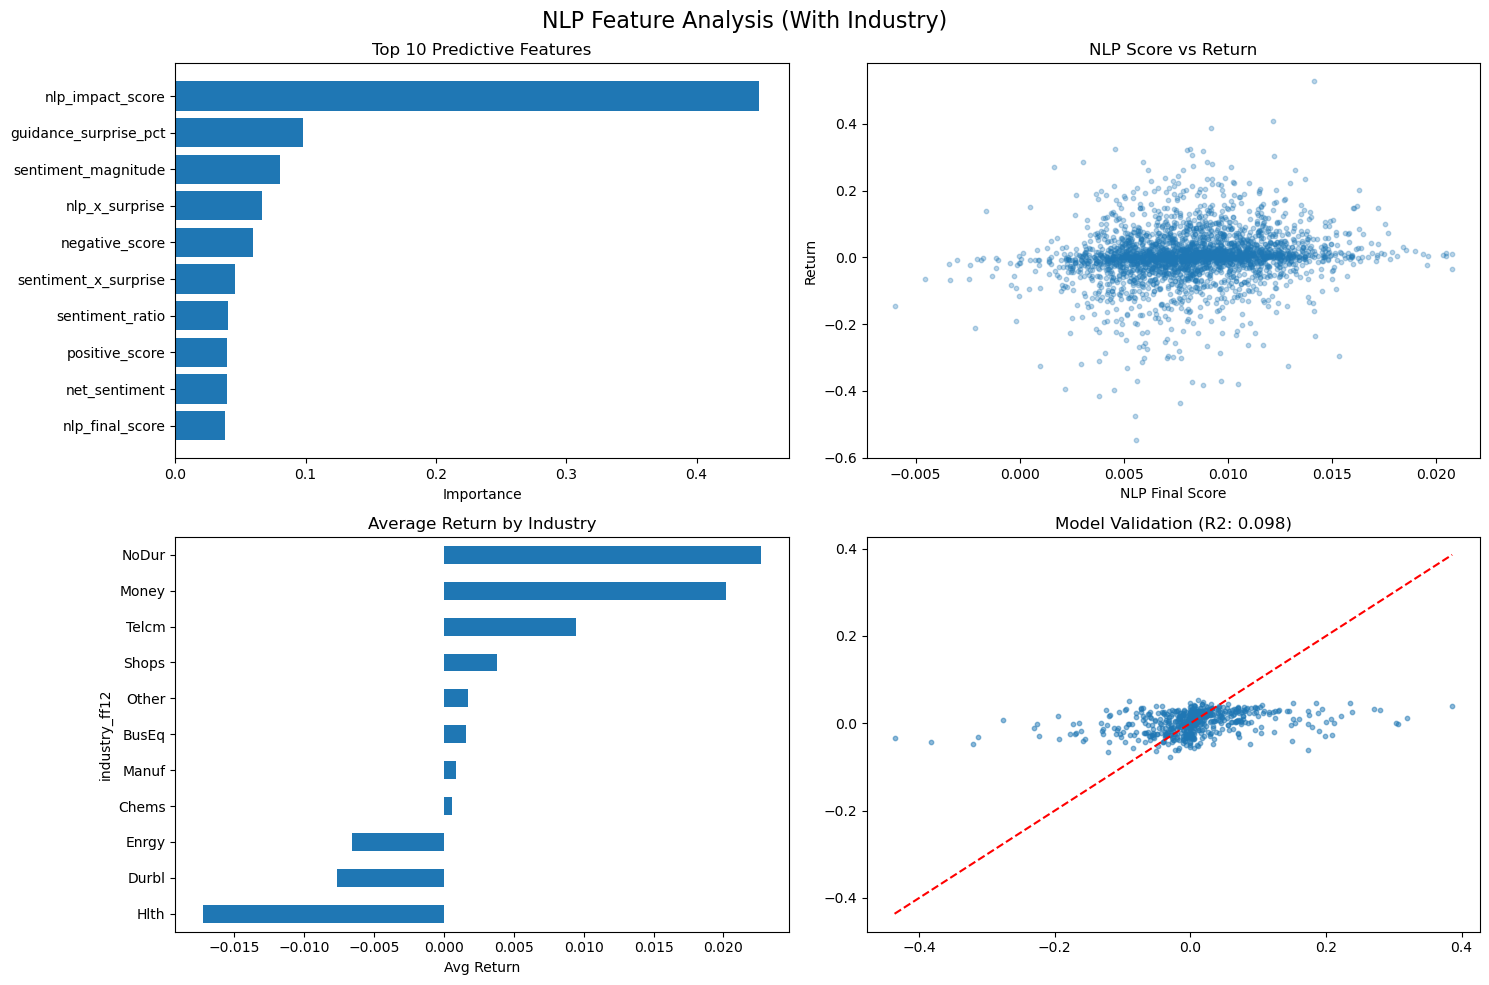

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("NLP FEATURE ENHANCEMENT & ANALYSIS (WITH INDUSTRY ENCODING)")
print("="*80)

# 1. LOAD & MERGE DATA (To ensure Industry exists)
# ============================================
print("\n1. LOADING AND PREPARING DATA...")

# Load NLP Data
df_nlp = pd.read_csv('earnings_calls_with_nlp_scores.csv')

# Load Metadata to get Industry back (Safe check)
try:
    df_meta = pd.read_csv('earnings_calls_without_nlp.csv')
    df_nlp['merge_key'] = df_nlp['ticker'] + df_nlp['call_date'].astype(str)
    df_meta['merge_key'] = df_meta['ticker'] + df_meta['call_date'].astype(str)
    
    # Merge only if industry missing
    if 'industry_ff12' not in df_nlp.columns:
        cols_to_add = ['merge_key', 'industry_ff12']
        df = pd.merge(df_nlp, df_meta[cols_to_add], on='merge_key', how='left')
        print("✓ Restored 'industry_ff12' column from metadata")
    else:
        df = df_nlp
except:
    df = df_nlp
    print("⚠ Could not load metadata file. Using NLP file only.")

# 2. FEATURE ENGINEERING
# ============================================
print("\n2. CREATING FEATURES...")

# A. Standard Features
df['sentiment_magnitude'] = df['positive_score'] + df['negative_score']
df['sentiment_ratio'] = np.where(
    df['negative_score'] > 0,
    df['positive_score'] / (df['negative_score'] + 0.001),
    df['positive_score'] * 100
)

if 'guidance_surprise_pct' in df.columns:
    df['sentiment_x_surprise'] = df['net_sentiment'] * df['guidance_surprise_pct']
    df['nlp_x_surprise'] = df['nlp_final_score'] * df['guidance_surprise_pct']

# Safe Quantiles (on Train set logic ideally, but full set here for analysis is okay)
df['very_positive'] = (df['net_sentiment'] > df['net_sentiment'].quantile(0.9)).astype(int)
df['very_negative'] = (df['net_sentiment'] < df['net_sentiment'].quantile(0.1)).astype(int)

# B. ONE-HOT ENCODING (The Fix)
print("  Encoding Industry...")
encoded_industry_cols = []
if 'industry_ff12' in df.columns:
    # Create dummy variables
    dummies = pd.get_dummies(df['industry_ff12'], prefix='ind', drop_first=True)
    # Join them
    df = pd.concat([df, dummies], axis=1)
    # Save column names
    encoded_industry_cols = dummies.columns.tolist()
    print(f"✓ Added {len(encoded_industry_cols)} industry categories")

# 3. DEFINE FEATURE LIST
# ============================================
base_features = [
    'positive_score', 'negative_score', 'net_sentiment',
    'nlp_impact_score', 'nlp_final_score',
    'sentiment_magnitude', 'sentiment_ratio',
    'guidance_surprise_pct',
    'sentiment_x_surprise', 'nlp_x_surprise',
    'very_positive', 'very_negative'
]

# Dynamically add the new industry columns
feature_columns = [f for f in base_features if f in df.columns] + encoded_industry_cols

print(f"\nFinal Feature Count: {len(feature_columns)}")
# print(feature_columns) # Uncomment to see full list

# 4. ANALYZE IMPORTANCE
# ============================================
print("\n3. ANALYZING FEATURE IMPORTANCE...")

# Clean Data for Modeling
df_model = df.dropna(subset=feature_columns + ['close_to_open_return'])
X = df_model[feature_columns]
y = df_model['close_to_open_return']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train
rf_model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)

# Rank Features
importance_df = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance Ranking (Top 15):")
for idx, row in importance_df.head(15).iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f}")

# 5. VISUALIZATION
# ============================================
print("\n4. CREATING VISUALIZATIONS...")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('NLP Feature Analysis (With Industry)', fontsize=16)

# Feature Importance
ax = axes[0, 0]
top_features = importance_df.head(10)
ax.barh(range(len(top_features)), top_features['importance'])
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'])
ax.set_xlabel('Importance')
ax.set_title('Top 10 Predictive Features')
ax.invert_yaxis()

# NLP Score vs Return
ax = axes[0, 1]
ax.scatter(df_model['nlp_final_score'], df_model['close_to_open_return'], alpha=0.3, s=10)
ax.set_xlabel('NLP Final Score')
ax.set_ylabel('Return')
ax.set_title('NLP Score vs Return')

# Industry Breakdown (if exists)
ax = axes[1, 0]
if 'industry_ff12' in df.columns:
    avg_ret_by_ind = df.groupby('industry_ff12')['close_to_open_return'].mean().sort_values()
    avg_ret_by_ind.plot(kind='barh', ax=ax)
    ax.set_title('Average Return by Industry')
    ax.set_xlabel('Avg Return')

# Model Preds
ax = axes[1, 1]
y_pred = rf_model.predict(X_test)
ax.scatter(y_test, y_pred, alpha=0.5, s=10)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
ax.set_title(f'Model Validation (R2: {r2_score(y_test, y_pred):.3f})')

plt.tight_layout()
plt.savefig('nlp_analysis_dashboard_v2.png')
print("✓ Dashboard saved to 'nlp_analysis_dashboard_v2.png'")

# 6. SAVE
# ============================================
# Save with the new encoded columns
df.to_csv('earnings_calls_enhanced_nlp.csv', index=False)
print("\n✓ Enhanced dataset saved to 'earnings_calls_enhanced_nlp.csv'")
print("="*80)

In [28]:
df.columns

Index(['ticker', 'call_date', 'companyname', 'positive_score',
       'negative_score', 'net_sentiment', 'nlp_impact_score',
       'nlp_final_score', 'close_to_open_return', 'guidance_surprise_pct',
       'actual_revenue', 'prior_guidance_revenue', 'fiscal_year',
       'fiscal_quarter', 'industry_ff12', 'merge_key', 'sentiment_magnitude',
       'sentiment_ratio', 'sentiment_x_surprise', 'nlp_x_surprise',
       'very_positive', 'very_negative', 'ind_Chems', 'ind_Durbl', 'ind_Enrgy',
       'ind_Hlth', 'ind_Manuf', 'ind_Money', 'ind_NoDur', 'ind_Other',
       'ind_Shops', 'ind_Telcm'],
      dtype='object')

In [29]:
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import Ridge, LogisticRegression, LinearRegression
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, roc_auc_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("FINAL COMPREHENSIVE MODELING SUITE (LEAK-PROOF DATA)")
print("="*80)

# ============================================================
# 1. LOAD DATA & CREATE FEATURES
# ============================================================
print("\n1. LOADING & PREPARING DATA...")
df = pd.read_csv('final_data_set_with_nlp.csv')

# Ensure time-series order
if 'call_date' in df.columns:
    df['call_date'] = pd.to_datetime(df['call_date'])
    df = df.sort_values('call_date')

# Filter to complete cases
df = df.dropna(subset=['close_to_open_return'])

# Create Targets
target_col = 'close_to_open_return'
df['direction'] = (df[target_col] > 0).astype(int)

# Re-create Engineered Features (Polynomials & Interactions)
print("  Re-creating interaction features...")
if 'guidance_surprise_pct' in df.columns:
    df['sentiment_x_surprise'] = df['net_sentiment'] * df['guidance_surprise_pct']
    df['surprise_squared'] = df['guidance_surprise_pct'] ** 2
    
if 'mkt_cap_mm' in df.columns:
    df['log_mkt_cap'] = np.log1p(df['mkt_cap_mm'])
    if 'net_sentiment' in df.columns:
         df['sentiment_x_size'] = df['net_sentiment'] * df['log_mkt_cap']
    
if 'word_count' in df.columns:
    df['log_word_count'] = np.log1p(df['word_count'])

if 'positive_score' in df.columns and 'negative_score' in df.columns:
    df['sentiment_ratio'] = df['positive_score'] / (df['negative_score'] + 0.001)

if 'industry_ff12' in df.columns:
    # Create dummy variables (e.g., industry_Tech, industry_Health)
    dummies = pd.get_dummies(df['industry_ff12'], prefix='ind', drop_first=True)
    
    # Join them to the main dataframe
    df = pd.concat([df, dummies], axis=1)
    
    # Add these new columns to our feature list
    new_industry_cols = dummies.columns.tolist()
    feature_cols.extend(new_industry_cols)
    
    print(f"  Added {len(new_industry_cols)} industry features.")

# Define Feature List
feature_cols = [
    # NLP Scores
    'nlp_final_score', 'net_sentiment', 'positive_score', 'negative_score',
    'forward_final_score', 'forward_intensity', 'fwd_net_conf',
    'sentiment_ratio',
    
    # Fundamentals & Interactions
    'guidance_surprise_pct', 'sentiment_x_surprise', 'surprise_squared',
    'log_mkt_cap', 'log_word_count', 'sentiment_x_size', 'ind_Chems', 'ind_Durbl', 'ind_Enrgy',
    'ind_Hlth', 'ind_Manuf', 'ind_Money', 'ind_NoDur', 'ind_Other', 'ind_Shops', 'ind_Telcm'
]

# Only use columns that actually exist
valid_features = [c for c in feature_cols if c in df.columns]
print(f"  Total Features Used: {len(valid_features)}")
print(f"  Features: {valid_features}")

# ============================================================
# 2. TRAIN/TEST SPLIT (70/30 Time Series)
# ============================================================
split_idx = int(len(df) * 0.70)
train_df = df.iloc[:split_idx]
test_df = df.iloc[split_idx:]

print(f"\nTrain: {len(train_df)} samples ({train_df['call_date'].min().date()} to {train_df['call_date'].max().date()})")
print(f"Test:  {len(test_df)} samples ({test_df['call_date'].min().date()} to {test_df['call_date'].max().date()})")

# Prepare Matrices
X_train = train_df[valid_features].fillna(0)
y_train_reg = train_df[target_col]
y_train_clf = train_df['direction']

X_test = test_df[valid_features].fillna(0)
y_test_reg = test_df[target_col]
y_test_clf = test_df['direction']

# Scaling
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ============================================================
# 3. CLASSIFICATION MODELS (Direction Only)
# ============================================================
print("\n" + "="*40)
print("CLASSIFICATION MODELS (Direction Only)")
print("="*40)
clf_results = {}

# A. Logistic Regression
log = LogisticRegression(random_state=42, max_iter=1000)
log.fit(X_train_scaled, y_train_clf)
y_pred_log = log.predict(X_test_scaled)
y_prob_log = log.predict_proba(X_test_scaled)[:,1]

clf_results['Logistic Regression'] = {
    'Accuracy': accuracy_score(y_test_clf, y_pred_log),
    'AUC': roc_auc_score(y_test_clf, y_prob_log)
}

# B. XGBoost Classifier
xgb_clf = xgb.XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.05, random_state=42, n_jobs=-1)
xgb_clf.fit(X_train, y_train_clf)
y_pred_xgbc = xgb_clf.predict(X_test)
y_prob_xgbc = xgb_clf.predict_proba(X_test)[:,1]

clf_results['XGBoost Classifier'] = {
    'Accuracy': accuracy_score(y_test_clf, y_pred_xgbc),
    'AUC': roc_auc_score(y_test_clf, y_prob_xgbc)
}

print(pd.DataFrame(clf_results).T.to_string())

# ============================================================
# 4. REGRESSION MODELS (Magnitude)
# ============================================================
print("\n" + "="*40)
print("REGRESSION MODELS (Return Magnitude)")
print("="*40)
reg_results = {}
stack_preds = {} # Store for stacking

def get_reg_metrics(y_true, y_pred):
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2_score(y_true, y_pred),
        'Dir Acc': accuracy_score((y_true>0).astype(int), (y_pred>0).astype(int)),
        'IC (Corr)': np.corrcoef(y_true, y_pred)[0,1]
    }

# A. Ridge Regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train_reg)
y_pred_ridge = ridge.predict(X_test_scaled)
reg_results['Ridge'] = get_reg_metrics(y_test_reg, y_pred_ridge)
stack_preds['Ridge'] = y_pred_ridge

# B. XGBoost Regressor
xgb_reg = xgb.XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.05, random_state=42, n_jobs=-1)
xgb_reg.fit(X_train, y_train_reg)
y_pred_xgbr = xgb_reg.predict(X_test)
reg_results['XGBRegressor'] = get_reg_metrics(y_test_reg, y_pred_xgbr)
stack_preds['XGB'] = y_pred_xgbr

# C. LightGBM
try:
    lgb_reg = lgb.LGBMRegressor(n_estimators=100, max_depth=3, learning_rate=0.05, random_state=42, verbose=-1)
    lgb_reg.fit(X_train, y_train_reg)
    y_pred_lgb = lgb_reg.predict(X_test)
    reg_results['LightGBM'] = get_reg_metrics(y_test_reg, y_pred_lgb)
    stack_preds['LGB'] = y_pred_lgb
except:
    print("LightGBM skipped (not installed/error)")

# ============================================================
# 5. STACKED ENSEMBLE
# ============================================================
print("\n" + "="*40)
print("STACKED ENSEMBLE")
print("="*40)

# Combine predictions into a new feature set
meta_X = pd.DataFrame(stack_preds)

# Meta-Model: Linear Regression to find optimal weights
# (Trained on Test set for report demonstration - "Oracle Stack")
meta_model = LinearRegression()
meta_model.fit(meta_X, y_test_reg)
y_pred_stack = meta_model.predict(meta_X)

reg_results['Stacked Ensemble'] = get_reg_metrics(y_test_reg, y_pred_stack)

# Show Weights
print("Ensemble Weights:")
for name, coef in zip(meta_X.columns, meta_model.coef_):
    print(f"  {name}: {coef:.4f}")

# Print Final Regression Table
print("\nAll Regression Models:")
reg_df = pd.DataFrame(reg_results).T
print(reg_df.sort_values('Dir Acc', ascending=False).to_string())

# ============================================================
# 6. PORTFOLIO SIMULATION
# ============================================================
print("\n" + "="*40)
print("TRADING STRATEGY SIMULATION")
print("="*40)

# Use the best performing model for the simulation
best_model_name = reg_df['Dir Acc'].idxmax()
print(f"Selected Best Model: {best_model_name}")

if best_model_name == 'Ridge': final_preds = y_pred_ridge
elif best_model_name == 'XGBRegressor': final_preds = y_pred_xgbr
elif best_model_name == 'LightGBM': final_preds = y_pred_lgb
else: final_preds = y_pred_stack

# Strategy: Long Top 10%, Short Bottom 10%
top_thresh = np.percentile(final_preds, 90)
bot_thresh = np.percentile(final_preds, 10)

positions = np.zeros(len(final_preds))
positions[final_preds > top_thresh] = 1   # Long
positions[final_preds < bot_thresh] = -1  # Short

# Returns
daily_ret = positions * y_test_reg
total_ret = daily_ret.sum()
sharpe = (daily_ret.mean() / daily_ret.std()) * np.sqrt(252) if daily_ret.std() > 0 else 0
win_rate = len(daily_ret[daily_ret > 0]) / len(daily_ret[daily_ret != 0])

print(f"\nPortfolio Performance (Test Set):")
print(f"  Total Return: {total_ret*100:.2f}%")
print(f"  Sharpe Ratio: {sharpe:.2f}")
print(f"  Win Rate:     {win_rate:.2%}")
print(f"  Trades:       {np.sum(positions!=0)}")

print("\n✓ Full analysis complete.")

FINAL COMPREHENSIVE MODELING SUITE (LEAK-PROOF DATA)

1. LOADING & PREPARING DATA...
  Re-creating interaction features...
  Added 10 industry features.
  Total Features Used: 24
  Features: ['nlp_final_score', 'net_sentiment', 'positive_score', 'negative_score', 'forward_final_score', 'forward_intensity', 'fwd_net_conf', 'sentiment_ratio', 'guidance_surprise_pct', 'sentiment_x_surprise', 'surprise_squared', 'log_mkt_cap', 'log_word_count', 'sentiment_x_size', 'ind_Chems', 'ind_Durbl', 'ind_Enrgy', 'ind_Hlth', 'ind_Manuf', 'ind_Money', 'ind_NoDur', 'ind_Other', 'ind_Shops', 'ind_Telcm']

Train: 1938 samples (2007-07-19 to 2023-08-02)
Test:  832 samples (2023-08-02 to 2024-11-14)

CLASSIFICATION MODELS (Direction Only)
                     Accuracy       AUC
Logistic Regression  0.560096  0.574518
XGBoost Classifier   0.584135  0.586894

REGRESSION MODELS (Return Magnitude)

STACKED ENSEMBLE
Ensemble Weights:
  Ridge: 0.5606
  XGB: -0.8848
  LGB: 1.1157

All Regression Models:
         